# ============================================================================
# TRAITEMENT DES OUTLIERS - ANALYSE COMPLÈTE
# ============================================================================

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats.mstats import winsorize
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10


### 1. CHARGEMENT DES DONNÉES

In [3]:
# Chargement des données
df = pd.read_csv('Credit_scoring/data/merged/train_merged.csv')

print("=" * 80)
print("APERÇU DES DONNÉES")
print("=" * 80)
print(f"\nDimensions du dataset: {df.shape}")
print(f"\nPremières lignes:\n{df.head()}")
print(f"\nInformations sur les colonnes:\n{df.info()}")
print(f"\nStatistiques descriptives:\n{df.describe()}")


APERÇU DES DONNÉES

Dimensions du dataset: (307511, 184)

Premières lignes:
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  CC_AMT_BALANCE_SUM CC_AMT_CREDIT

### 2. IDENTIFICATION DES VARIABLES NUMÉRIQUES

In [4]:
# uniquement les colonnes numériques
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

print("\n" + "=" * 80)
print("VARIABLES NUMÉRIQUES DÉTECTÉES")
print("=" * 80)
print(f"\nNombre de variables numériques: {len(numeric_columns)}")
print(f"Liste des variables: {numeric_columns}")


VARIABLES NUMÉRIQUES DÉTECTÉES

Nombre de variables numériques: 168
Liste des variables: ['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVI

### 3. DÉTECTION DES OUTLIERS - MÉTHODE IQR

In [5]:
print("\n" + "=" * 80)
print("DÉTECTION DES OUTLIERS - MÉTHODE IQR (INTERQUARTILE RANGE)")
print("=" * 80)

def detect_outliers_iqr(data, column):
    """
    Détecte les outliers avec la méthode IQR
    
    Paramètres:
    -----------
    data : DataFrame
    column : str - nom de la colonne
    
    Retourne:
    ---------
    outliers_mask : Series booléenne indiquant les outliers
    lower_bound : float - limite inférieure
    upper_bound : float - limite supérieure
    stats_dict : dict - statistiques détaillées
    """
    # Calcul des quartiles
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calcul des limites
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identification des outliers
    outliers_mask = (data[column] < lower_bound) | (data[column] > upper_bound)
    
    # Statistiques détaillées
    stats_dict = {
        'count': len(data[column]),
        'mean': data[column].mean(),
        'median': data[column].median(),
        'std': data[column].std(),
        'min': data[column].min(),
        'max': data[column].max(),
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers_count': outliers_mask.sum(),
        'outliers_percentage': (outliers_mask.sum() / len(data)) * 100
    }
    
    return outliers_mask, lower_bound, upper_bound, stats_dict

# Détection pour toutes les variables numériques
outliers_summary = {}

for col in numeric_columns:
    print(f"\n{'─' * 80}")
    print(f"Variable: {col}")
    print(f"{'─' * 80}")
    
    mask, lower, upper, stats = detect_outliers_iqr(df, col)
    outliers_summary[col] = {
        'mask': mask,
        'lower_bound': lower,
        'upper_bound': upper,
        'stats': stats
    }
    
    print(f"\nStatistiques descriptives:")
    print(f"  Nombre d'observations: {stats['count']}")
    print(f"  Moyenne: {stats['mean']:.2f}")
    print(f"  Médiane: {stats['median']:.2f}")
    print(f"  Écart-type: {stats['std']:.2f}")
    print(f"  Minimum: {stats['min']:.2f}")
    print(f"  Maximum: {stats['max']:.2f}")
    
    print(f"\nQuartiles et IQR:")
    print(f"  Q1 (25%): {stats['Q1']:.2f}")
    print(f"  Q3 (75%): {stats['Q3']:.2f}")
    print(f"  IQR: {stats['IQR']:.2f}")
    
    print(f"\nLimites de détection:")
    print(f"  Limite inférieure: {stats['lower_bound']:.2f}")
    print(f"  Limite supérieure: {stats['upper_bound']:.2f}")
    
    print(f"\nOutliers détectés:")
    print(f"  Nombre: {stats['outliers_count']}")
    print(f"  Pourcentage: {stats['outliers_percentage']:.2f}%")



DÉTECTION DES OUTLIERS - MÉTHODE IQR (INTERQUARTILE RANGE)

────────────────────────────────────────────────────────────────────────────────
Variable: SK_ID_CURR
────────────────────────────────────────────────────────────────────────────────

Statistiques descriptives:
  Nombre d'observations: 307511
  Moyenne: 278180.52
  Médiane: 278202.00
  Écart-type: 102790.18
  Minimum: 100002.00
  Maximum: 456255.00

Quartiles et IQR:
  Q1 (25%): 189145.50
  Q3 (75%): 367142.50
  IQR: 177997.00

Limites de détection:
  Limite inférieure: -77850.00
  Limite supérieure: 634138.00

Outliers détectés:
  Nombre: 0
  Pourcentage: 0.00%

────────────────────────────────────────────────────────────────────────────────
Variable: TARGET
────────────────────────────────────────────────────────────────────────────────

Statistiques descriptives:
  Nombre d'observations: 307511
  Moyenne: 0.08
  Médiane: 0.00
  Écart-type: 0.27
  Minimum: 0.00
  Maximum: 1.00

Quartiles et IQR:
  Q1 (25%): 0.00
  Q3 (75%):

### 4. TABLEAU RÉCAPITULATIF DES OUTLIERS

In [6]:
print("\n" + "=" * 80)
print("TABLEAU RÉCAPITULATIF - OUTLIERS DÉTECTÉS")
print("=" * 80)

summary_data = []
for col in numeric_columns:
    summary_data.append({
        'Variable': col,
        'N_total': outliers_summary[col]['stats']['count'],
        'N_outliers': outliers_summary[col]['stats']['outliers_count'],
        'Pourcentage': f"{outliers_summary[col]['stats']['outliers_percentage']:.2f}%",
        'Limite_inf': f"{outliers_summary[col]['lower_bound']:.2f}",
        'Limite_sup': f"{outliers_summary[col]['upper_bound']:.2f}"
    })

summary_df = pd.DataFrame(summary_data)
print(f"\n{summary_df.to_string(index=False)}")


TABLEAU RÉCAPITULATIF - OUTLIERS DÉTECTÉS

                                                       Variable  N_total  N_outliers Pourcentage  Limite_inf Limite_sup
                                                     SK_ID_CURR   307511           0       0.00%   -77850.00  634138.00
                                                         TARGET   307511       24825       8.07%        0.00       0.00
                                                   CNT_CHILDREN   307511        4272       1.39%       -1.50       2.50
                                               AMT_INCOME_TOTAL   307511       14035       4.56%   -22500.00  337500.00
                                                     AMT_CREDIT   307511        6562       2.13%  -537975.00 1616625.00
                                                    AMT_ANNUITY   307511        7504       2.44%   -10584.00   61704.00
                                                AMT_GOODS_PRICE   307511       14728       4.79%  -423000.00 1341000

### 5. VISUALISATIONS


────────────────────────────────────────────────────────────────────────────────
Génération des graphiques pour : SK_ID_CURR


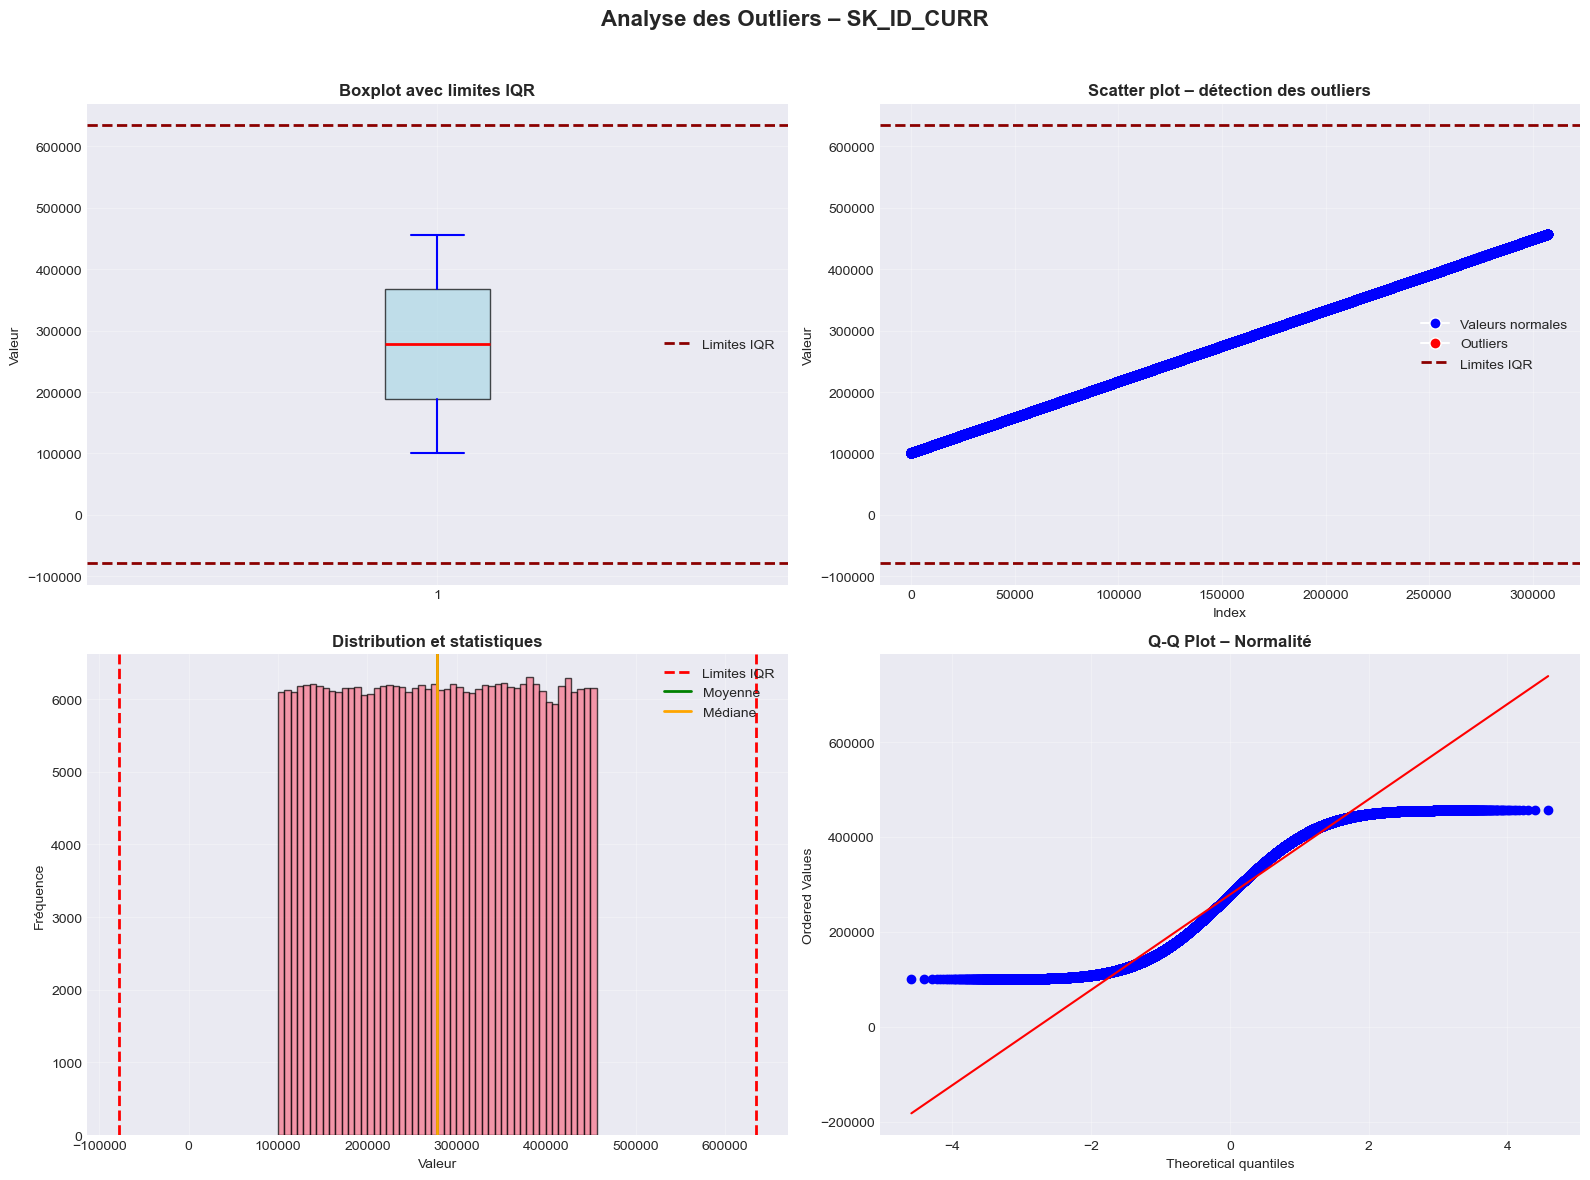


Résumé – SK_ID_CURR
  • Outliers détectés : 0 (0.00 %)
  • < Limite inférieure : 0
  • > Limite supérieure : 0

────────────────────────────────────────────────────────────────────────────────
Génération des graphiques pour : TARGET


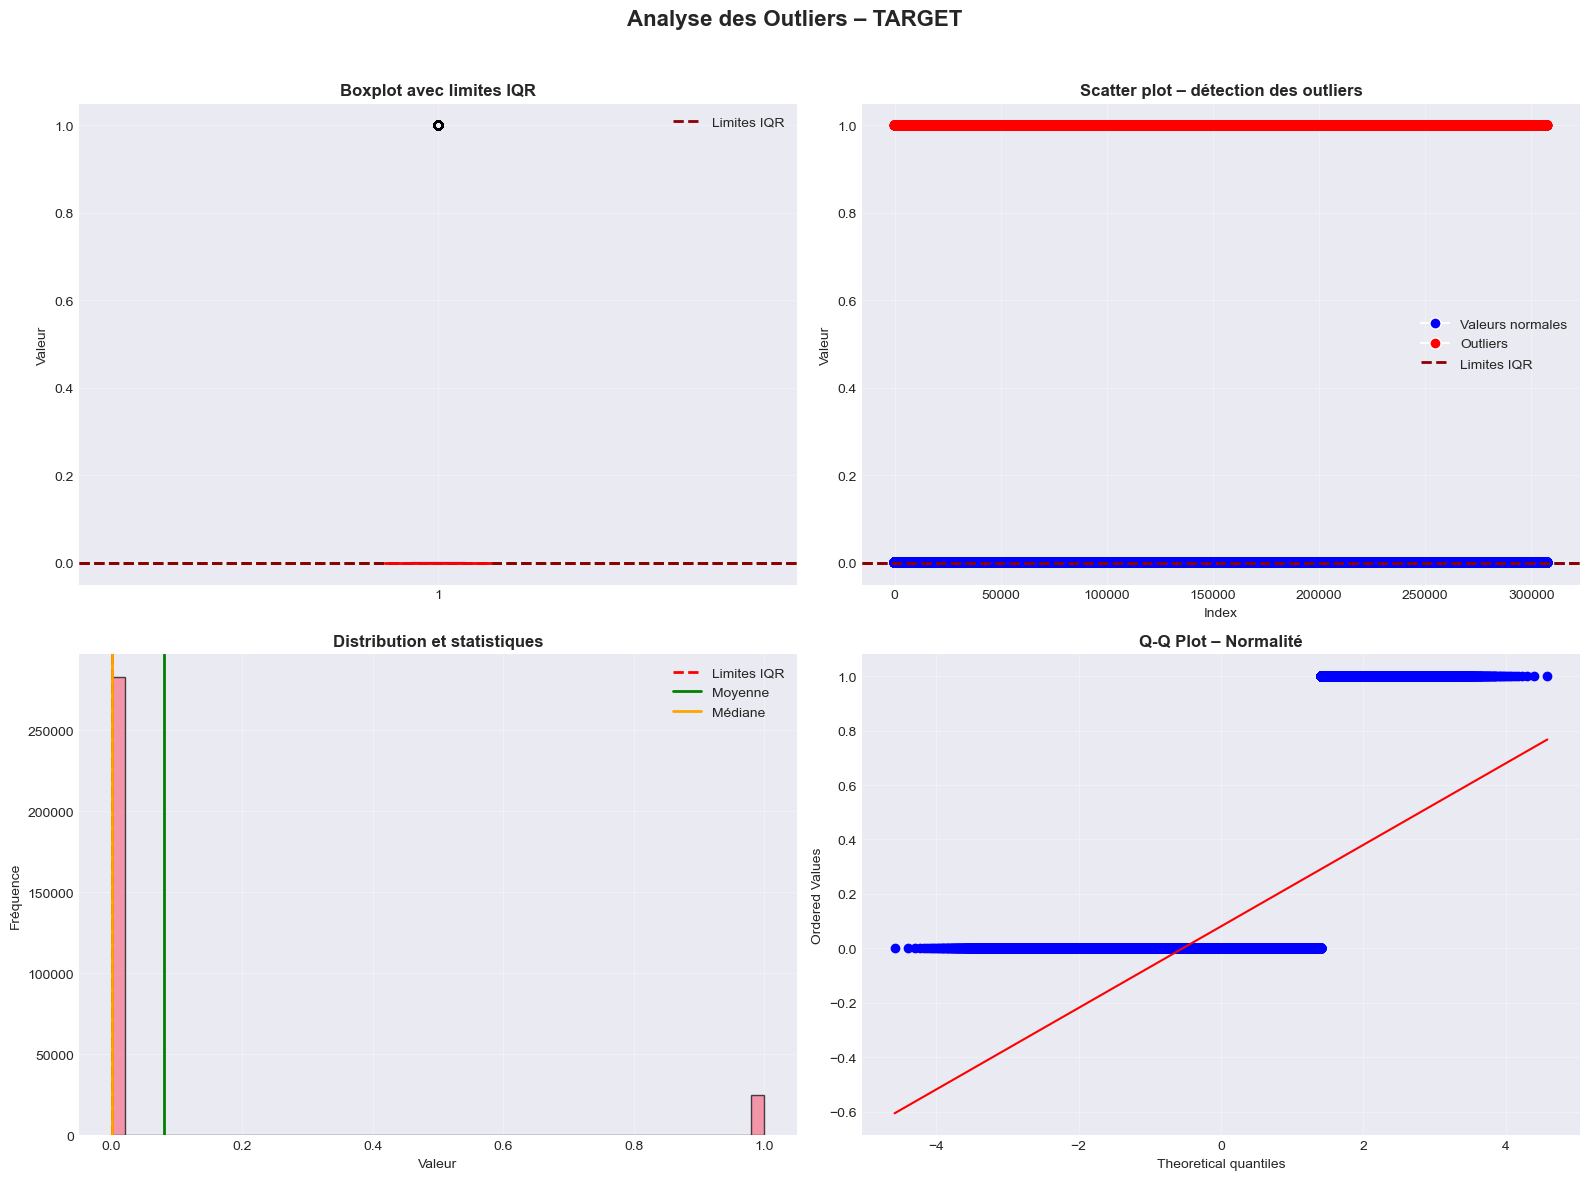


Résumé – TARGET
  • Outliers détectés : 24825 (8.07 %)
  • < Limite inférieure : 0
  • > Limite supérieure : 24825

────────────────────────────────────────────────────────────────────────────────
Génération des graphiques pour : CNT_CHILDREN


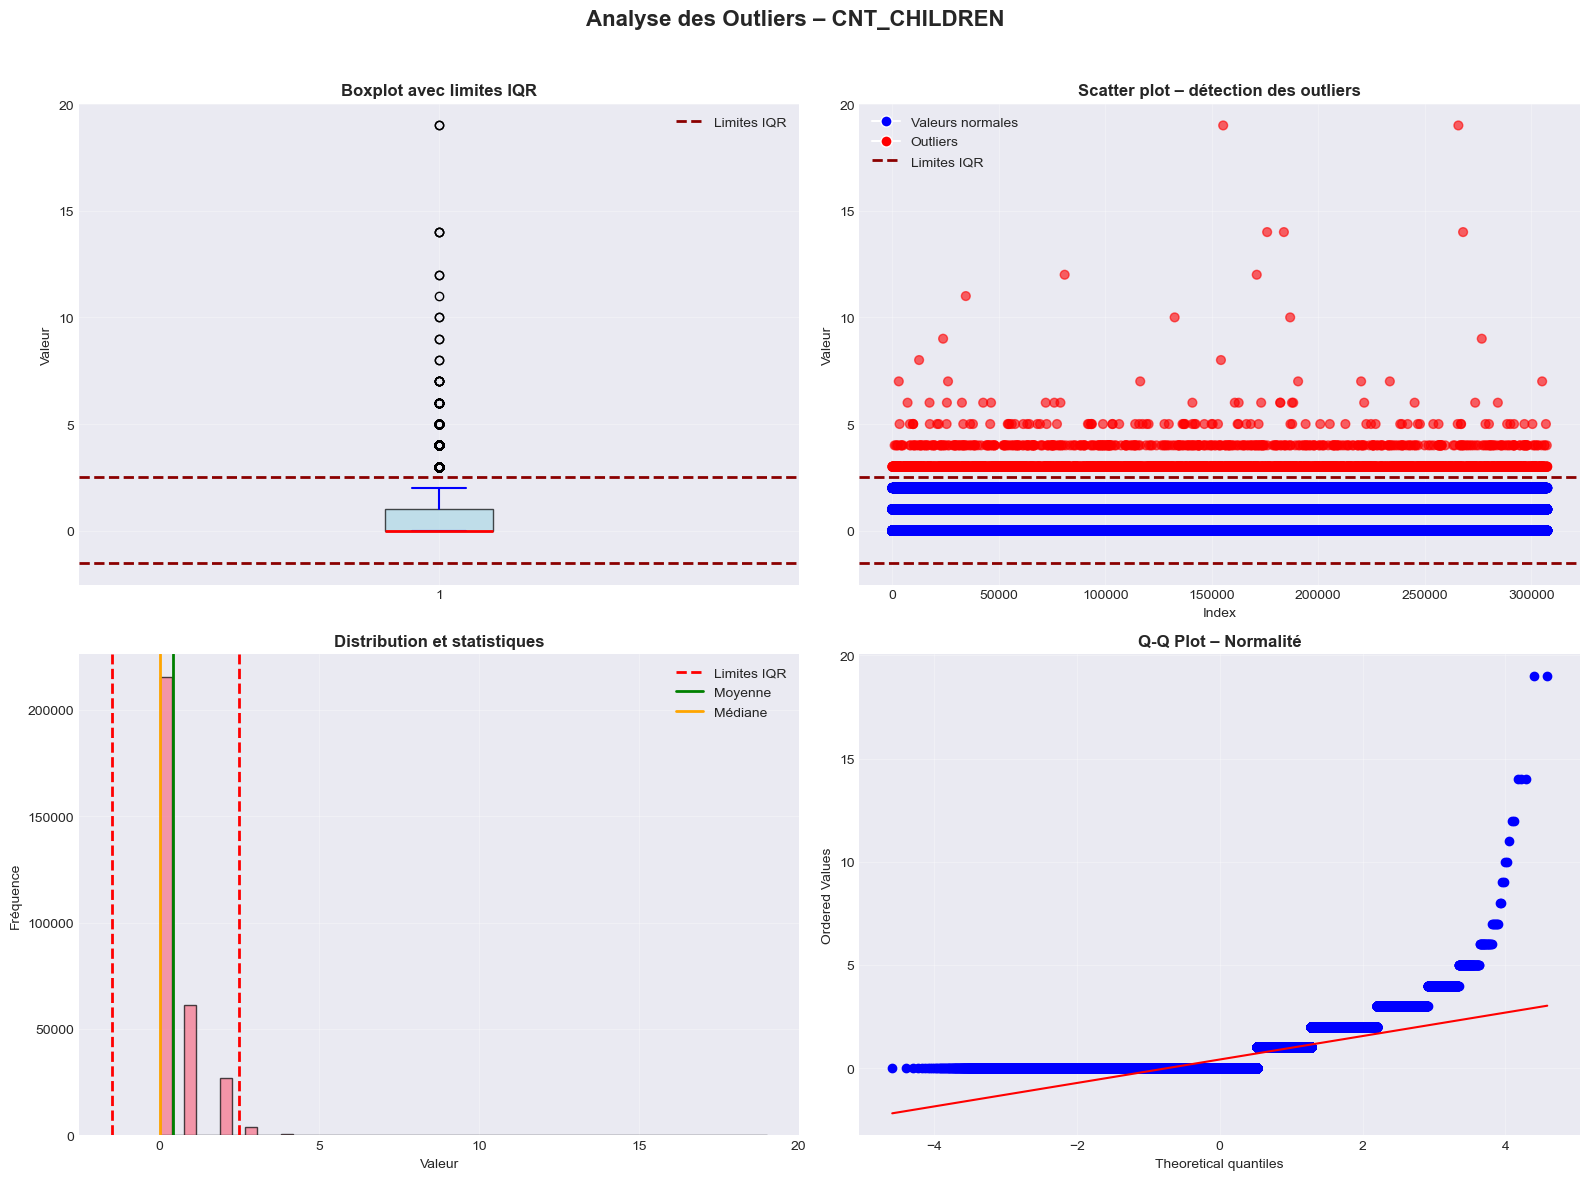


Résumé – CNT_CHILDREN
  • Outliers détectés : 4272 (1.39 %)
  • < Limite inférieure : 0
  • > Limite supérieure : 4272

────────────────────────────────────────────────────────────────────────────────
Génération des graphiques pour : AMT_INCOME_TOTAL


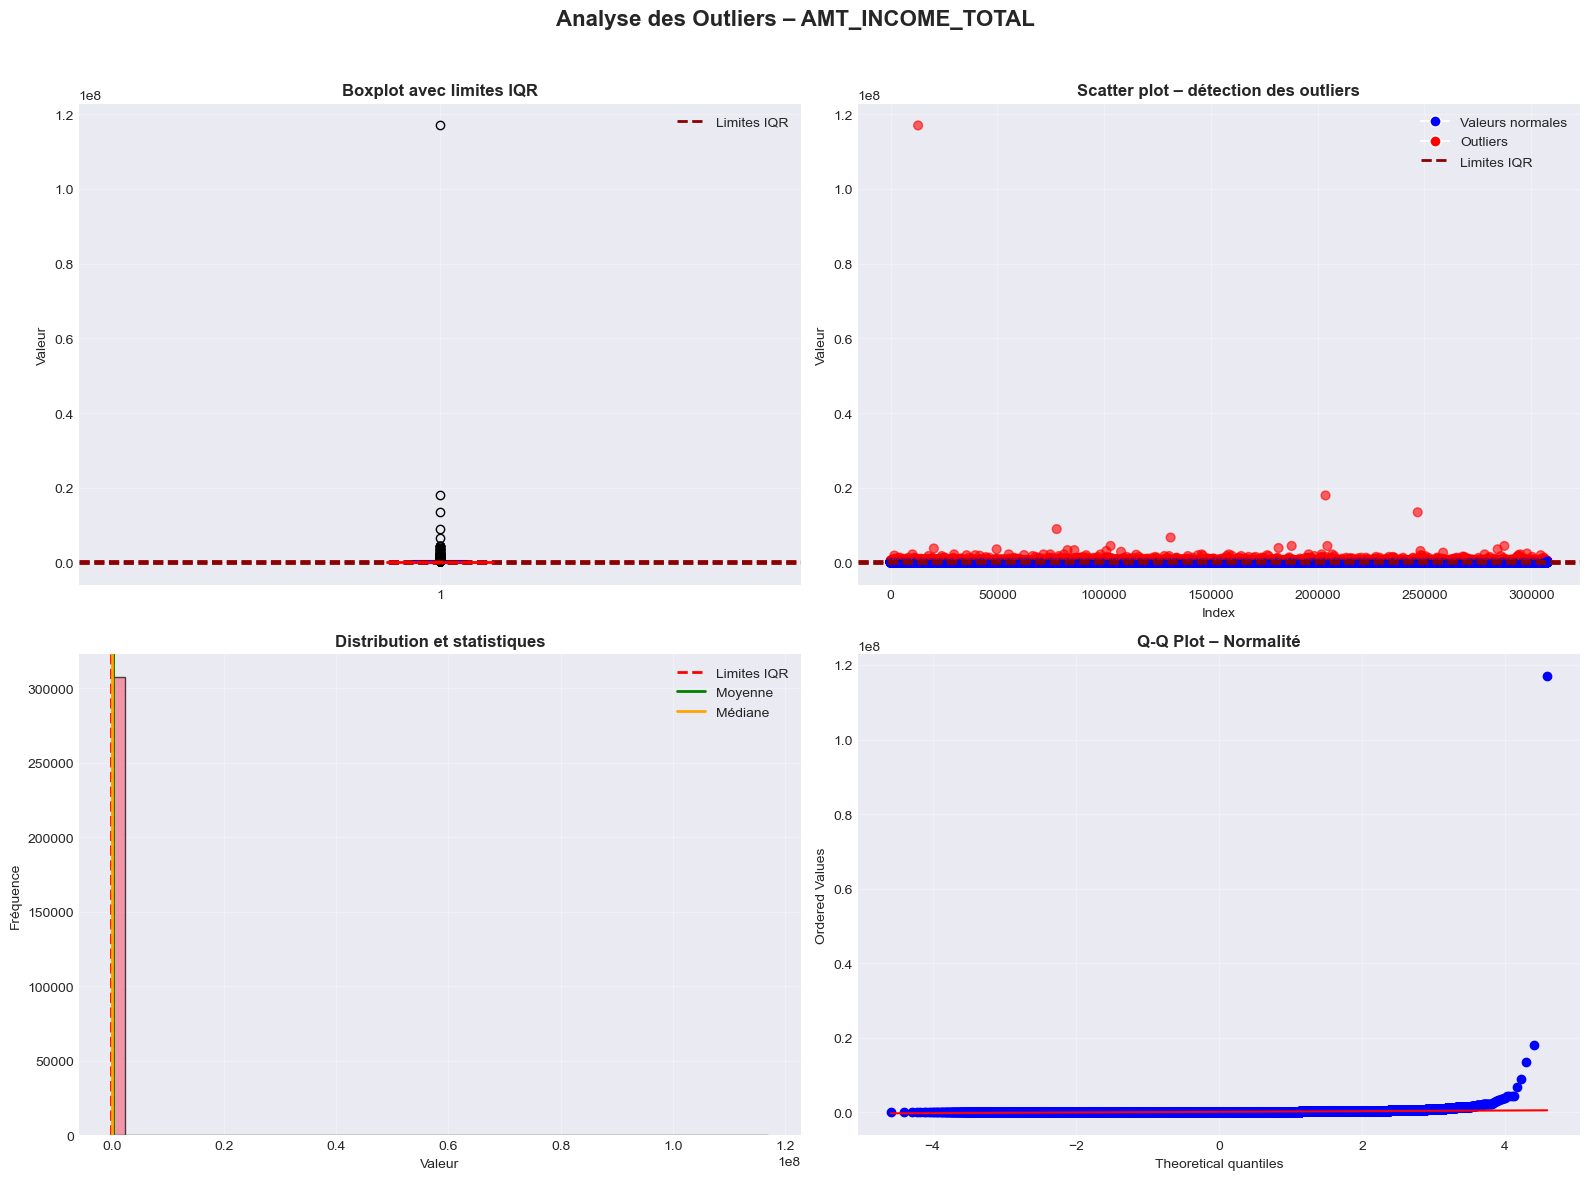


Résumé – AMT_INCOME_TOTAL
  • Outliers détectés : 14035 (4.56 %)
  • < Limite inférieure : 0
  • > Limite supérieure : 14035

────────────────────────────────────────────────────────────────────────────────
Génération des graphiques pour : AMT_CREDIT


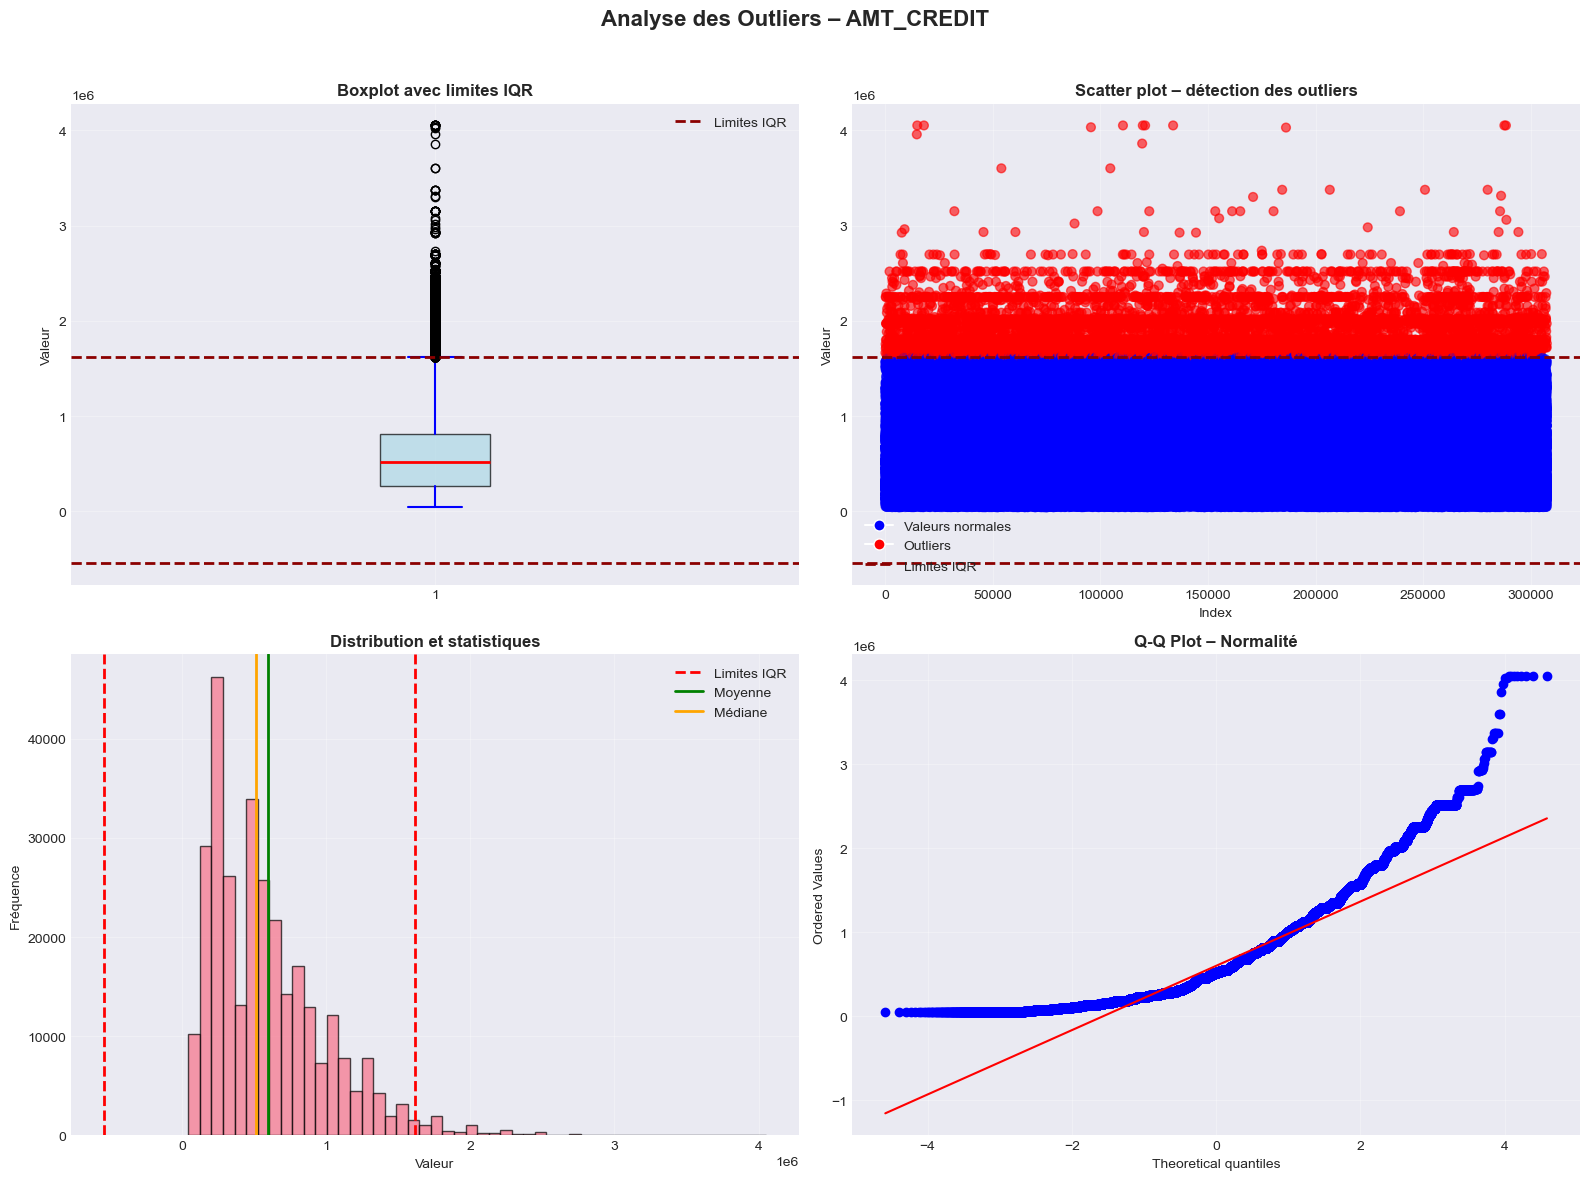


Résumé – AMT_CREDIT
  • Outliers détectés : 6562 (2.13 %)
  • < Limite inférieure : 0
  • > Limite supérieure : 6562

────────────────────────────────────────────────────────────────────────────────
Génération des graphiques pour : AMT_ANNUITY


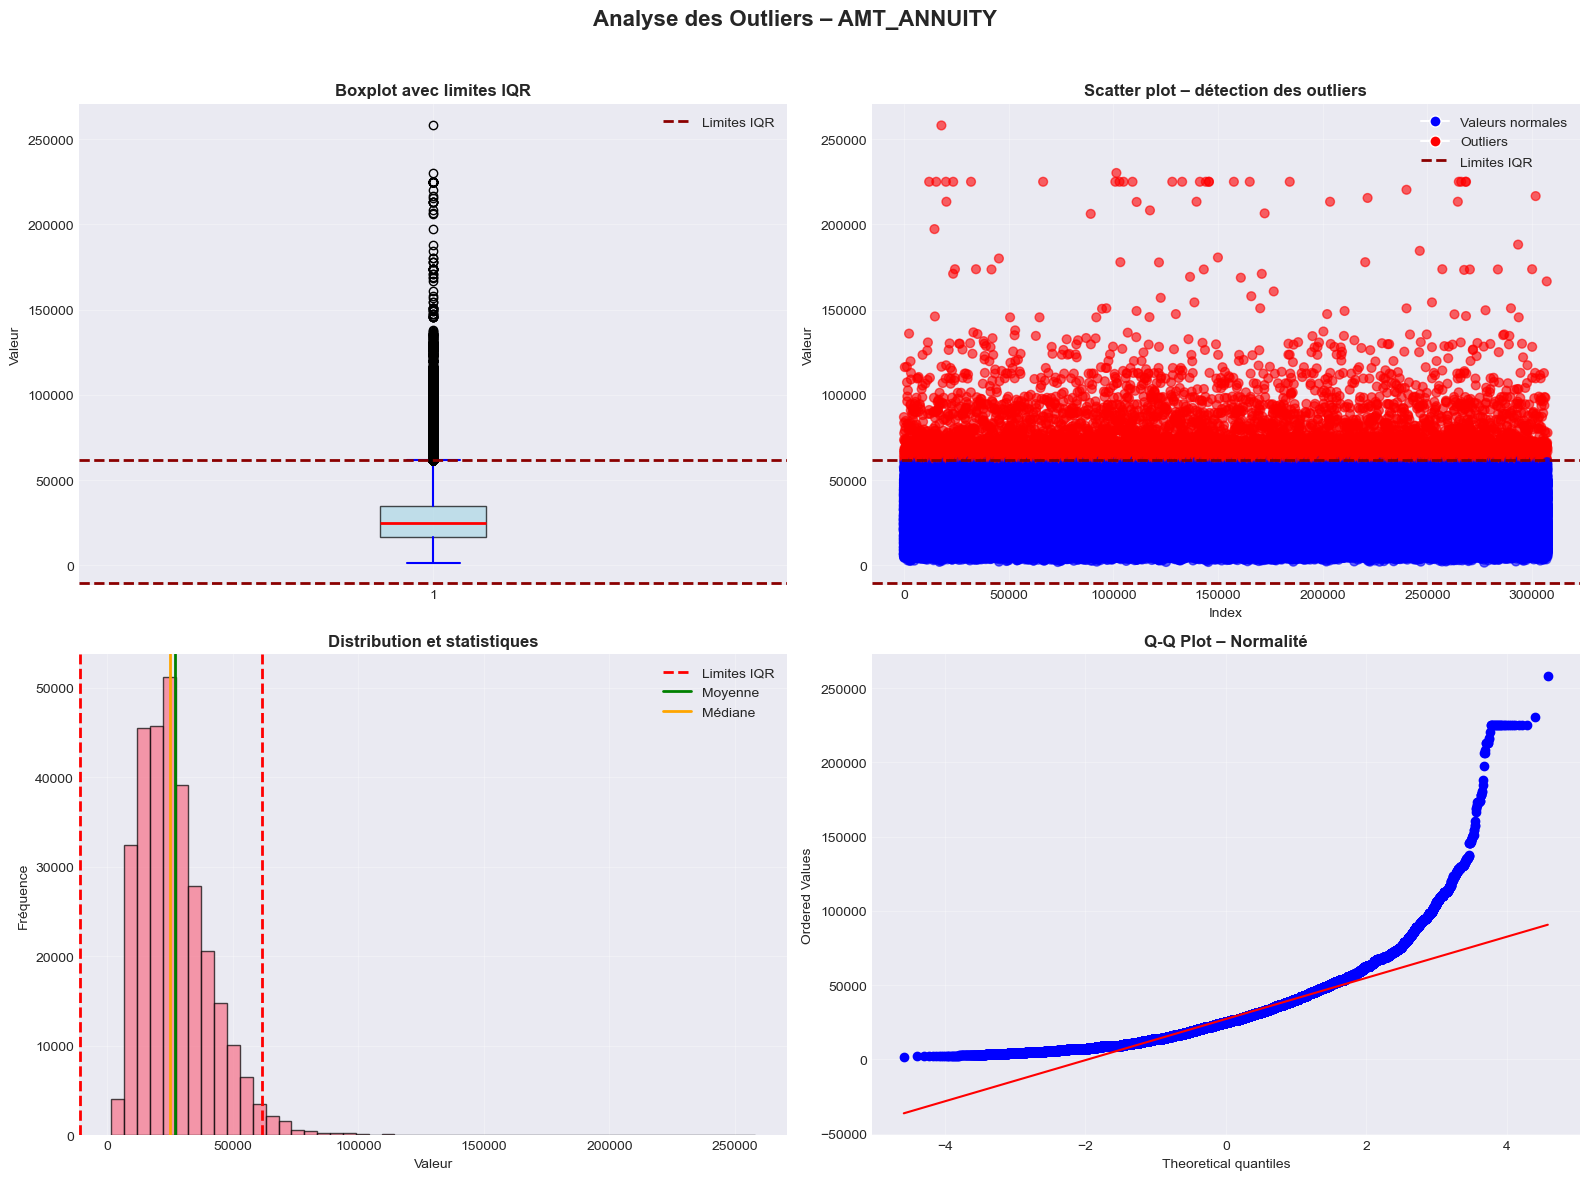


Résumé – AMT_ANNUITY
  • Outliers détectés : 7504 (2.44 %)
  • < Limite inférieure : 0
  • > Limite supérieure : 7504

────────────────────────────────────────────────────────────────────────────────
Génération des graphiques pour : AMT_GOODS_PRICE


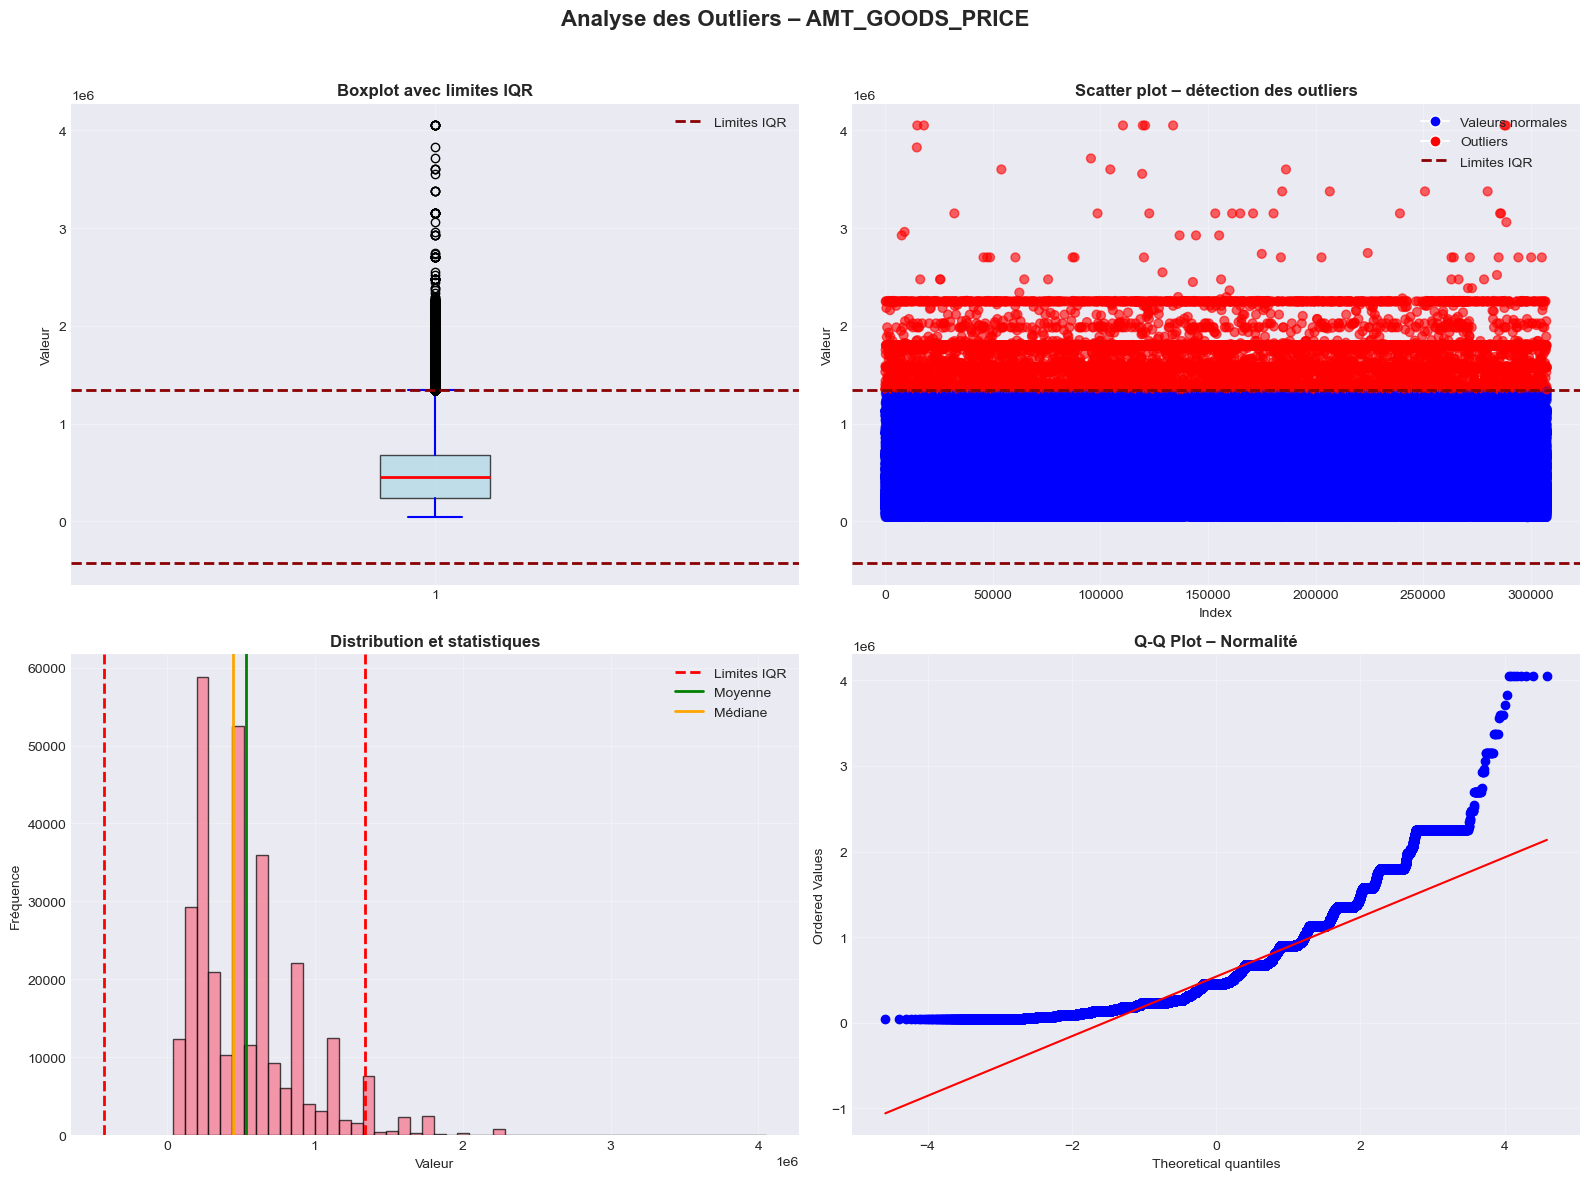


Résumé – AMT_GOODS_PRICE
  • Outliers détectés : 14728 (4.79 %)
  • < Limite inférieure : 0
  • > Limite supérieure : 14728

────────────────────────────────────────────────────────────────────────────────
Génération des graphiques pour : REGION_POPULATION_RELATIVE


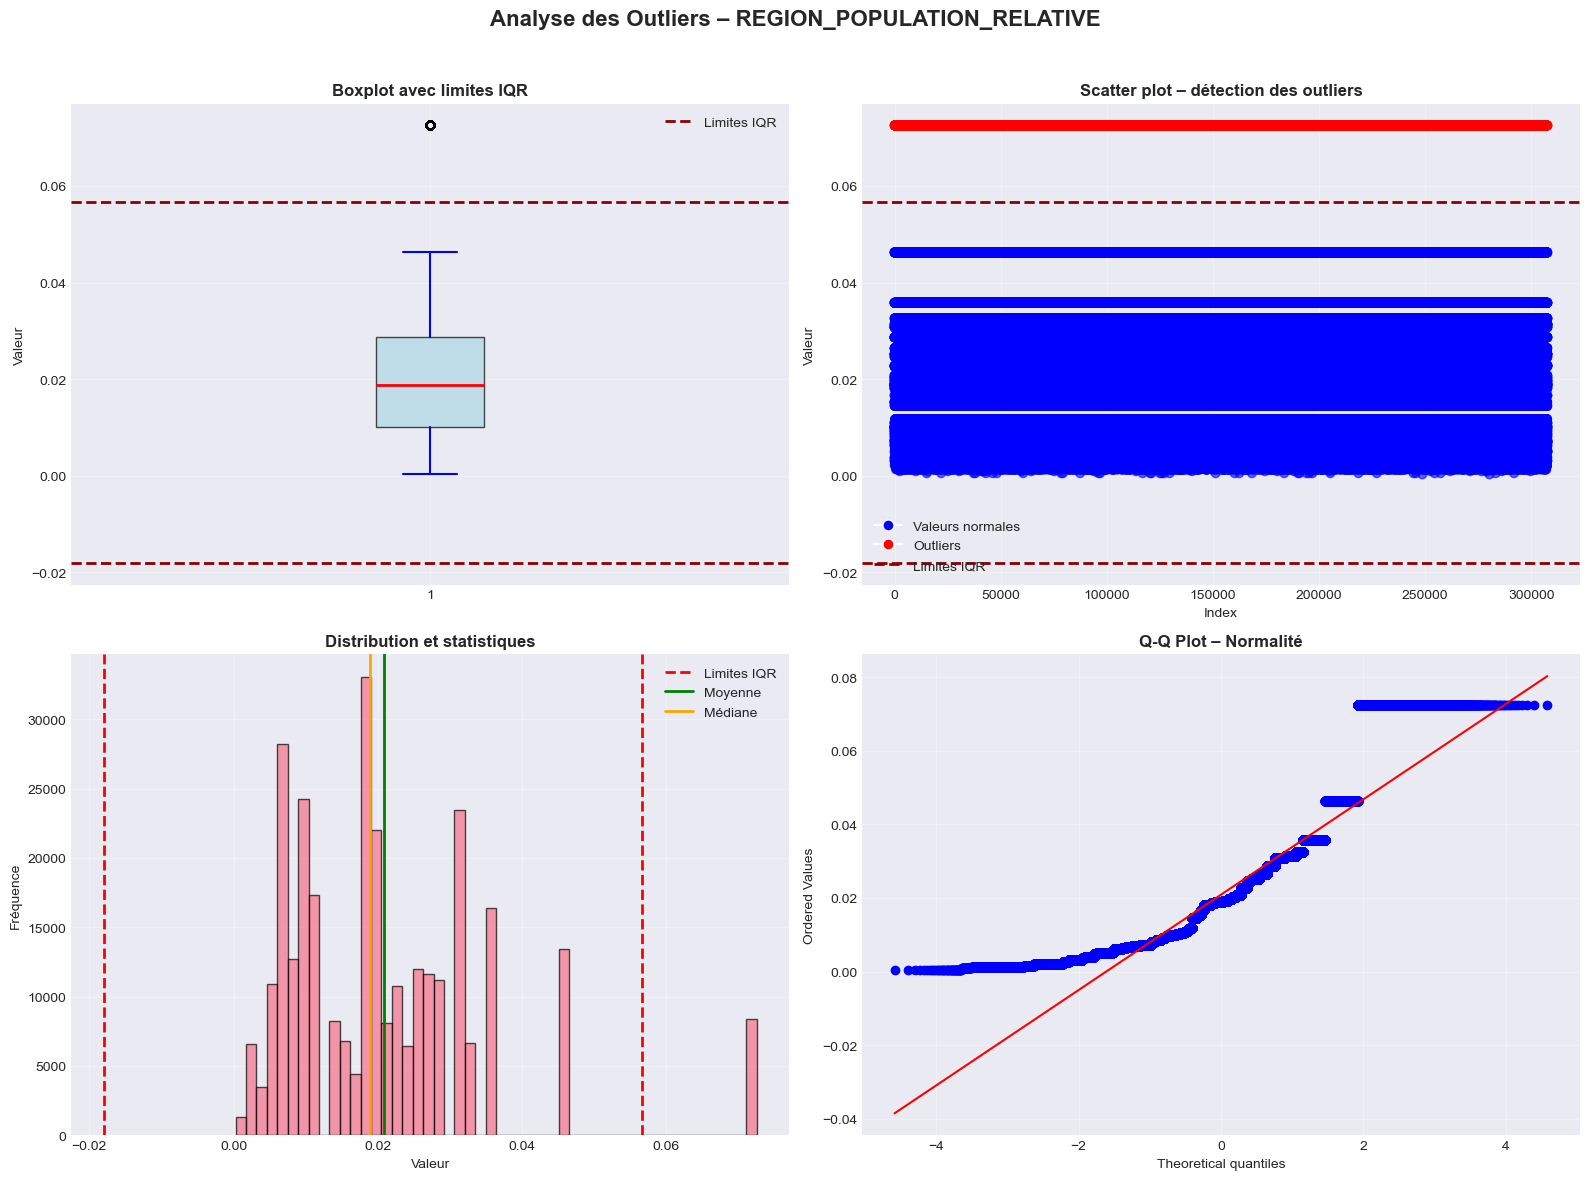


Résumé – REGION_POPULATION_RELATIVE
  • Outliers détectés : 8412 (2.74 %)
  • < Limite inférieure : 0
  • > Limite supérieure : 8412

────────────────────────────────────────────────────────────────────────────────
Génération des graphiques pour : DAYS_BIRTH


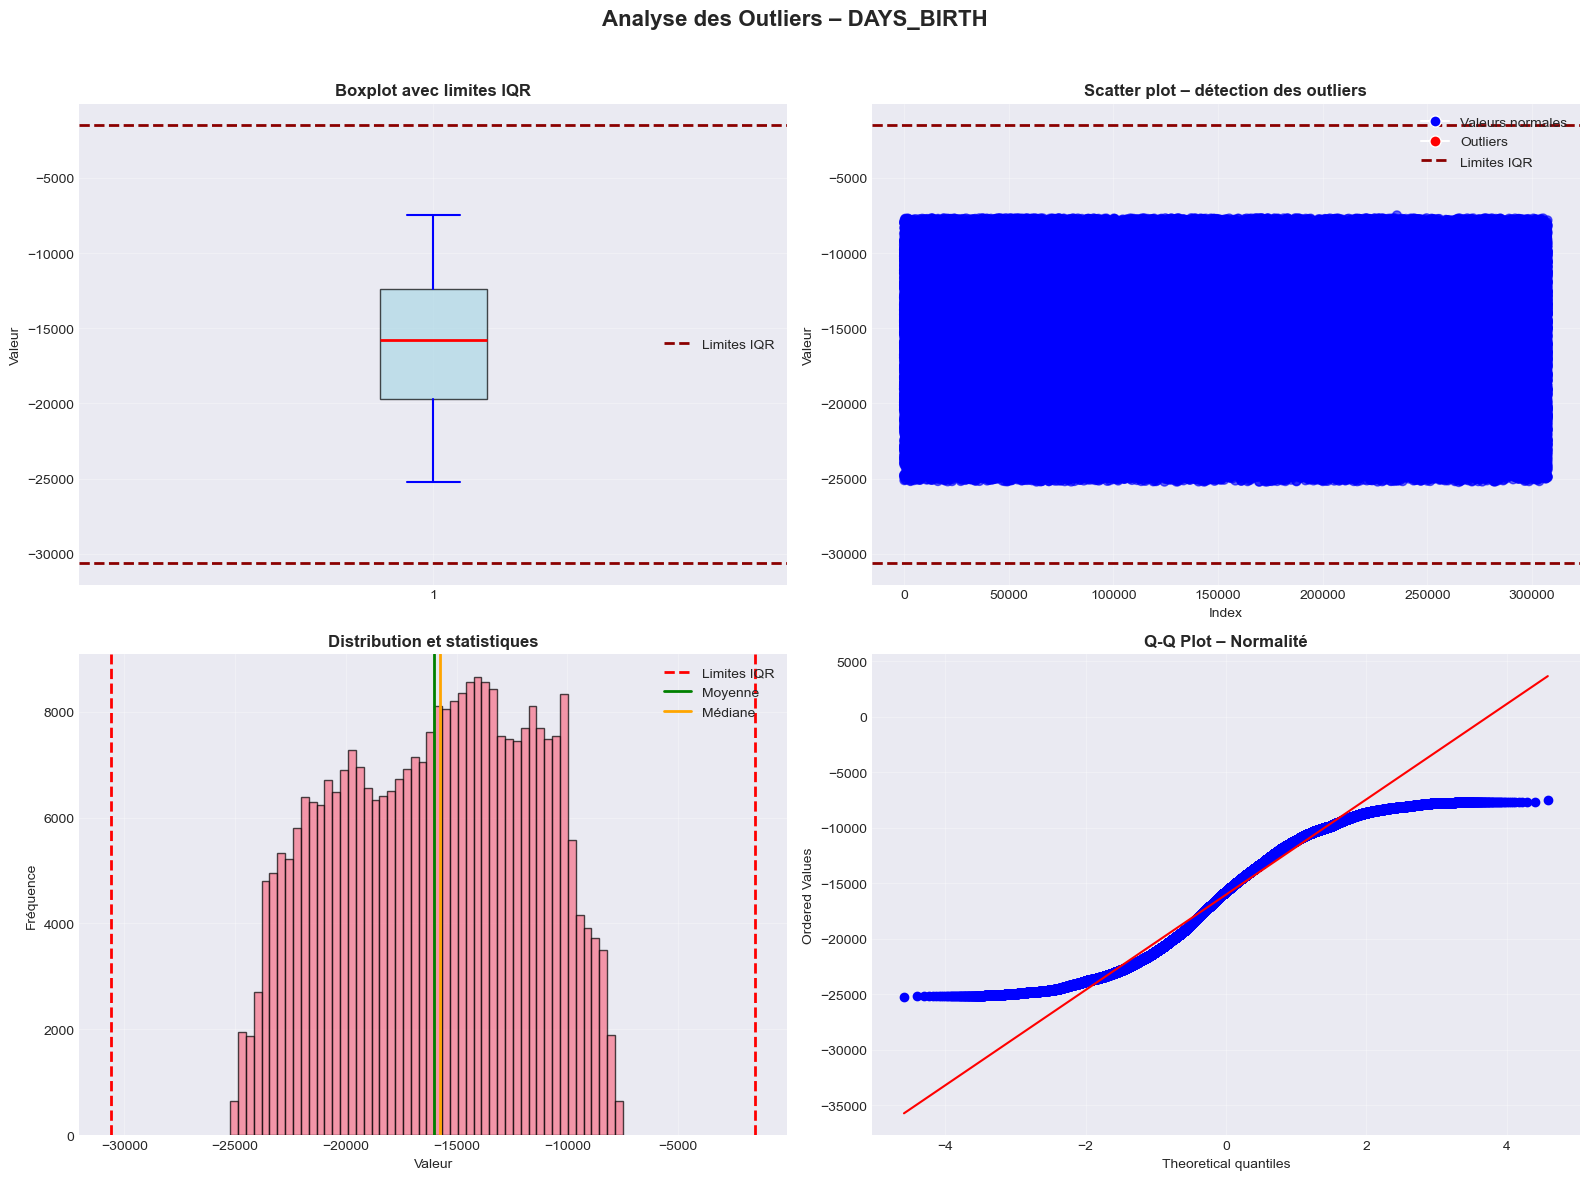


Résumé – DAYS_BIRTH
  • Outliers détectés : 0 (0.00 %)
  • < Limite inférieure : 0
  • > Limite supérieure : 0

────────────────────────────────────────────────────────────────────────────────
Génération des graphiques pour : DAYS_EMPLOYED


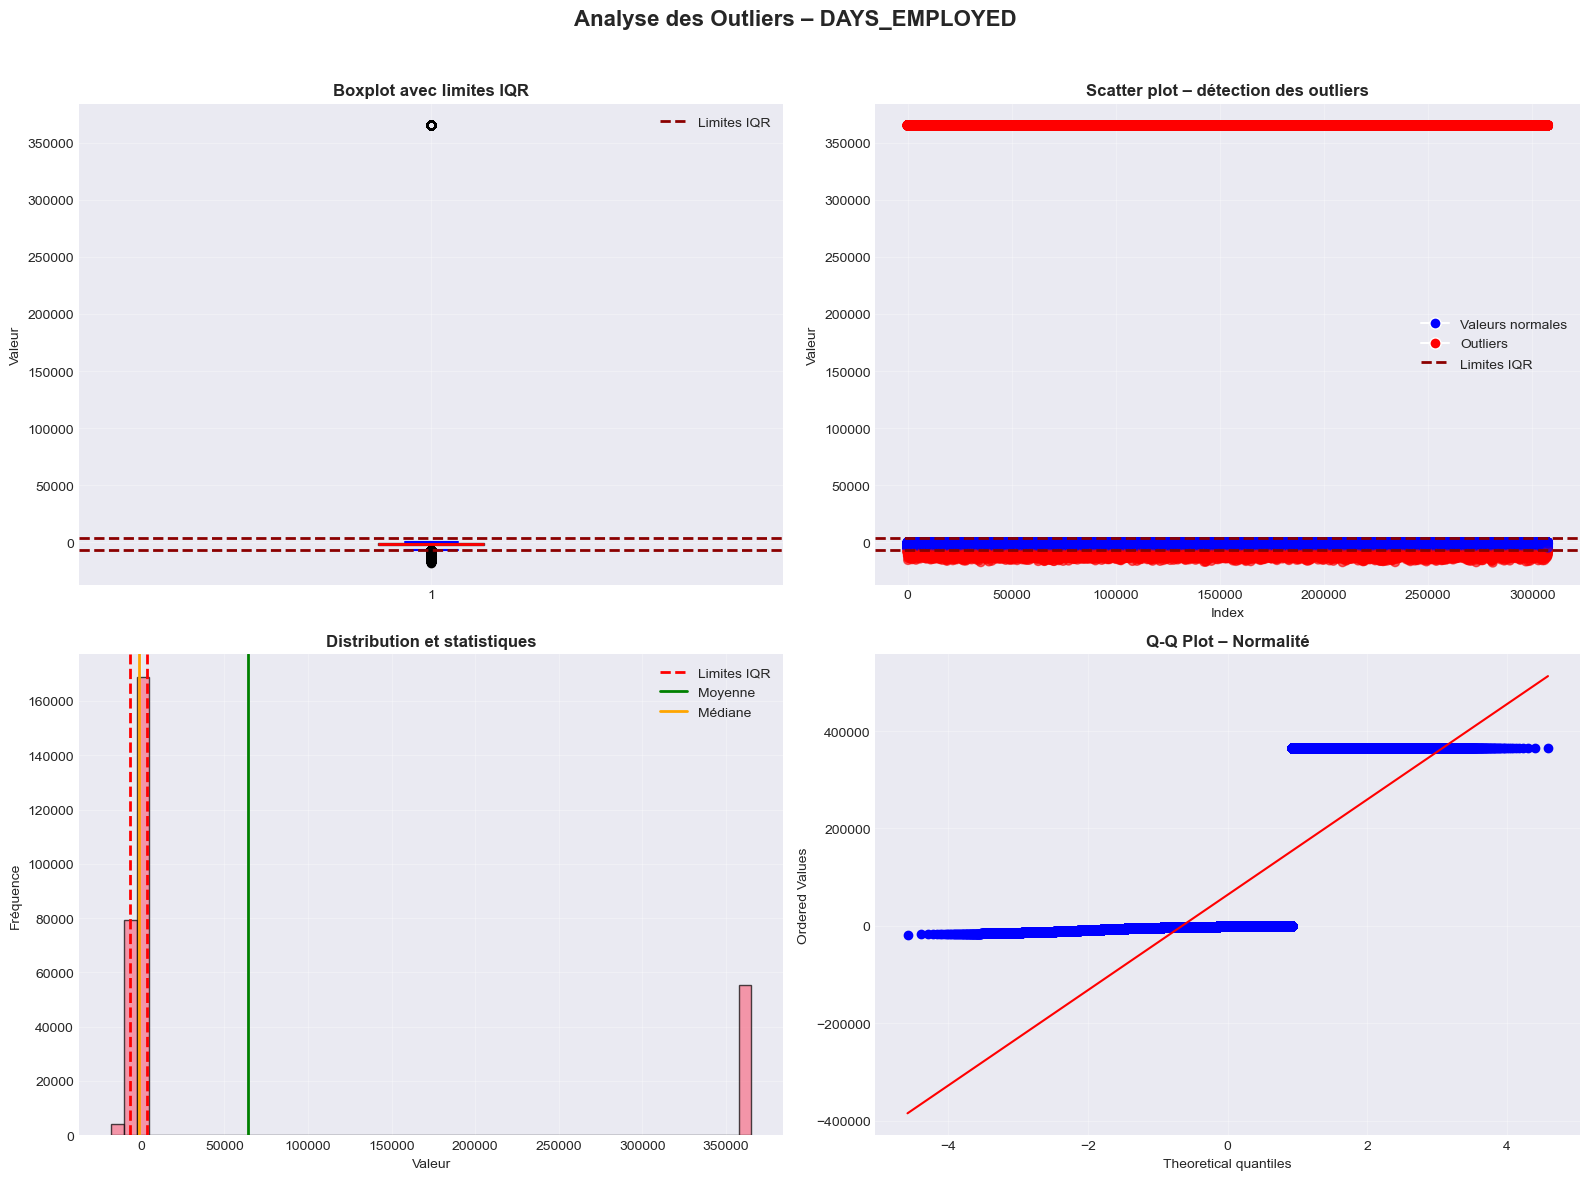


Résumé – DAYS_EMPLOYED
  • Outliers détectés : 72217 (23.48 %)
  • < Limite inférieure : 16843
  • > Limite supérieure : 55374

────────────────────────────────────────────────────────────────────────────────
Génération des graphiques pour : DAYS_REGISTRATION


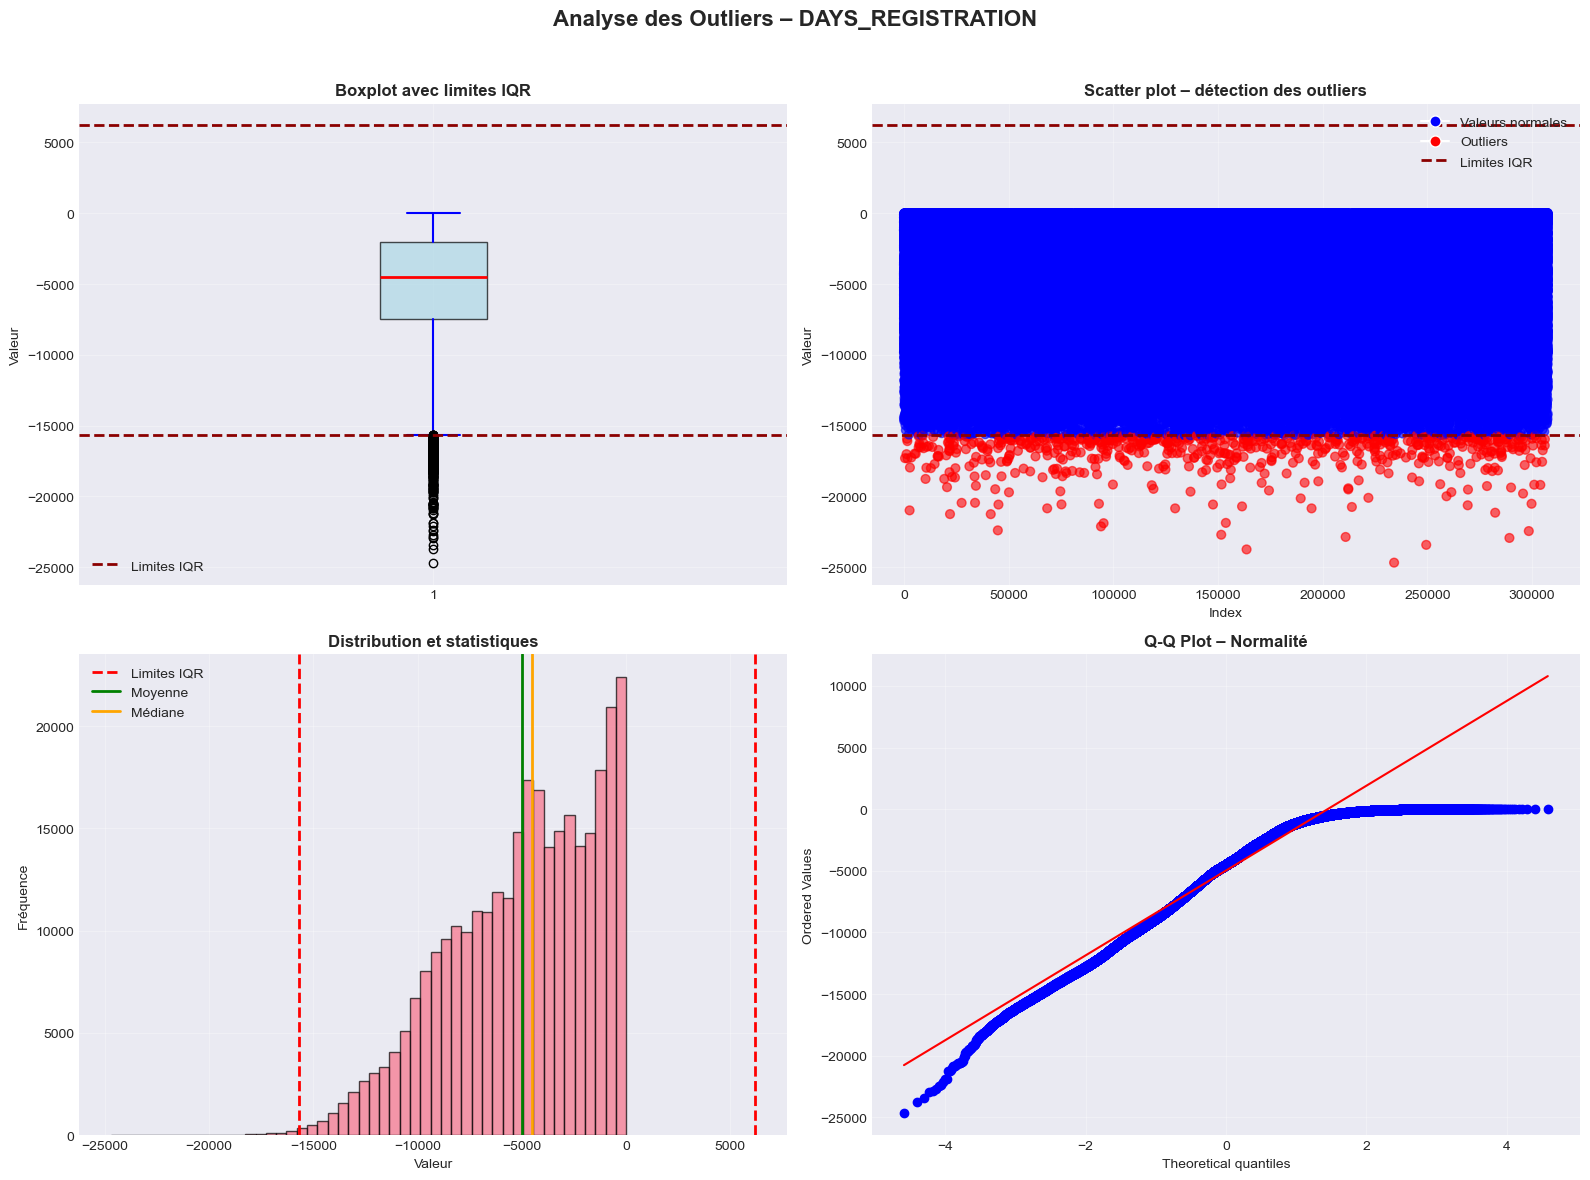


Résumé – DAYS_REGISTRATION
  • Outliers détectés : 659 (0.21 %)
  • < Limite inférieure : 659
  • > Limite supérieure : 0

────────────────────────────────────────────────────────────────────────────────
Génération des graphiques pour : DAYS_ID_PUBLISH


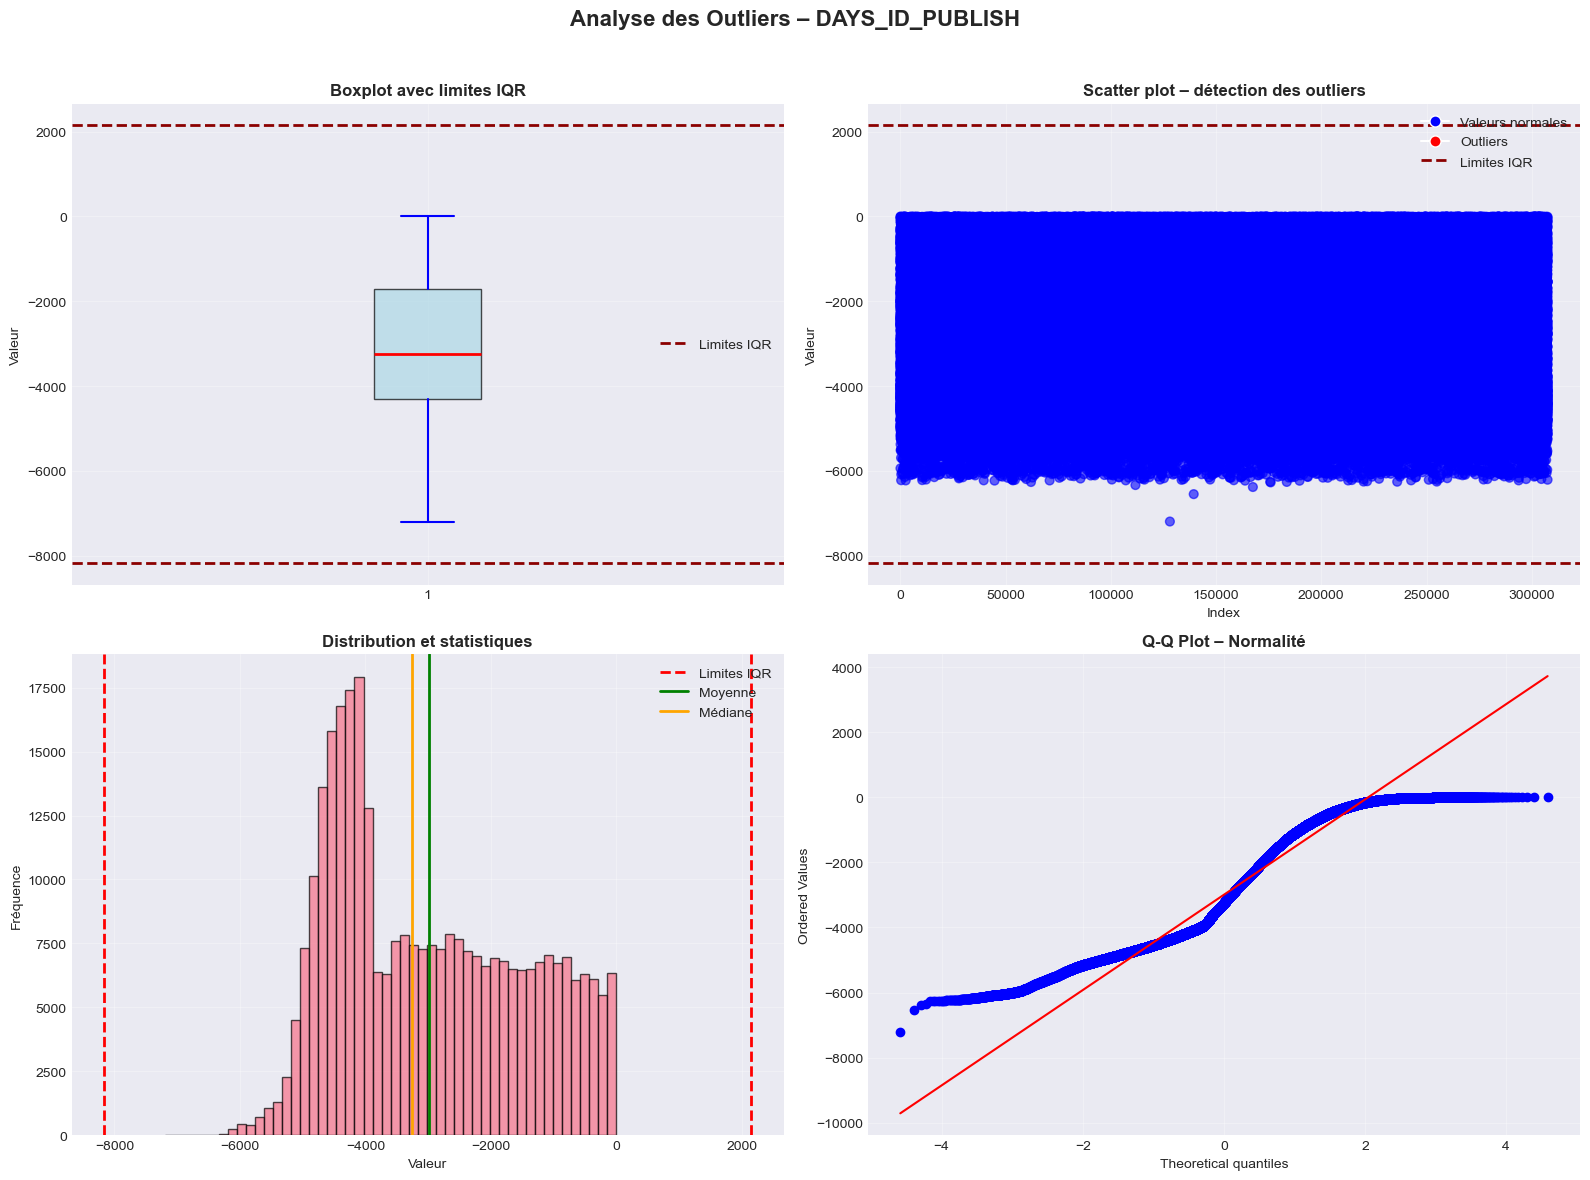


Résumé – DAYS_ID_PUBLISH
  • Outliers détectés : 0 (0.00 %)
  • < Limite inférieure : 0
  • > Limite supérieure : 0

────────────────────────────────────────────────────────────────────────────────
Génération des graphiques pour : OWN_CAR_AGE


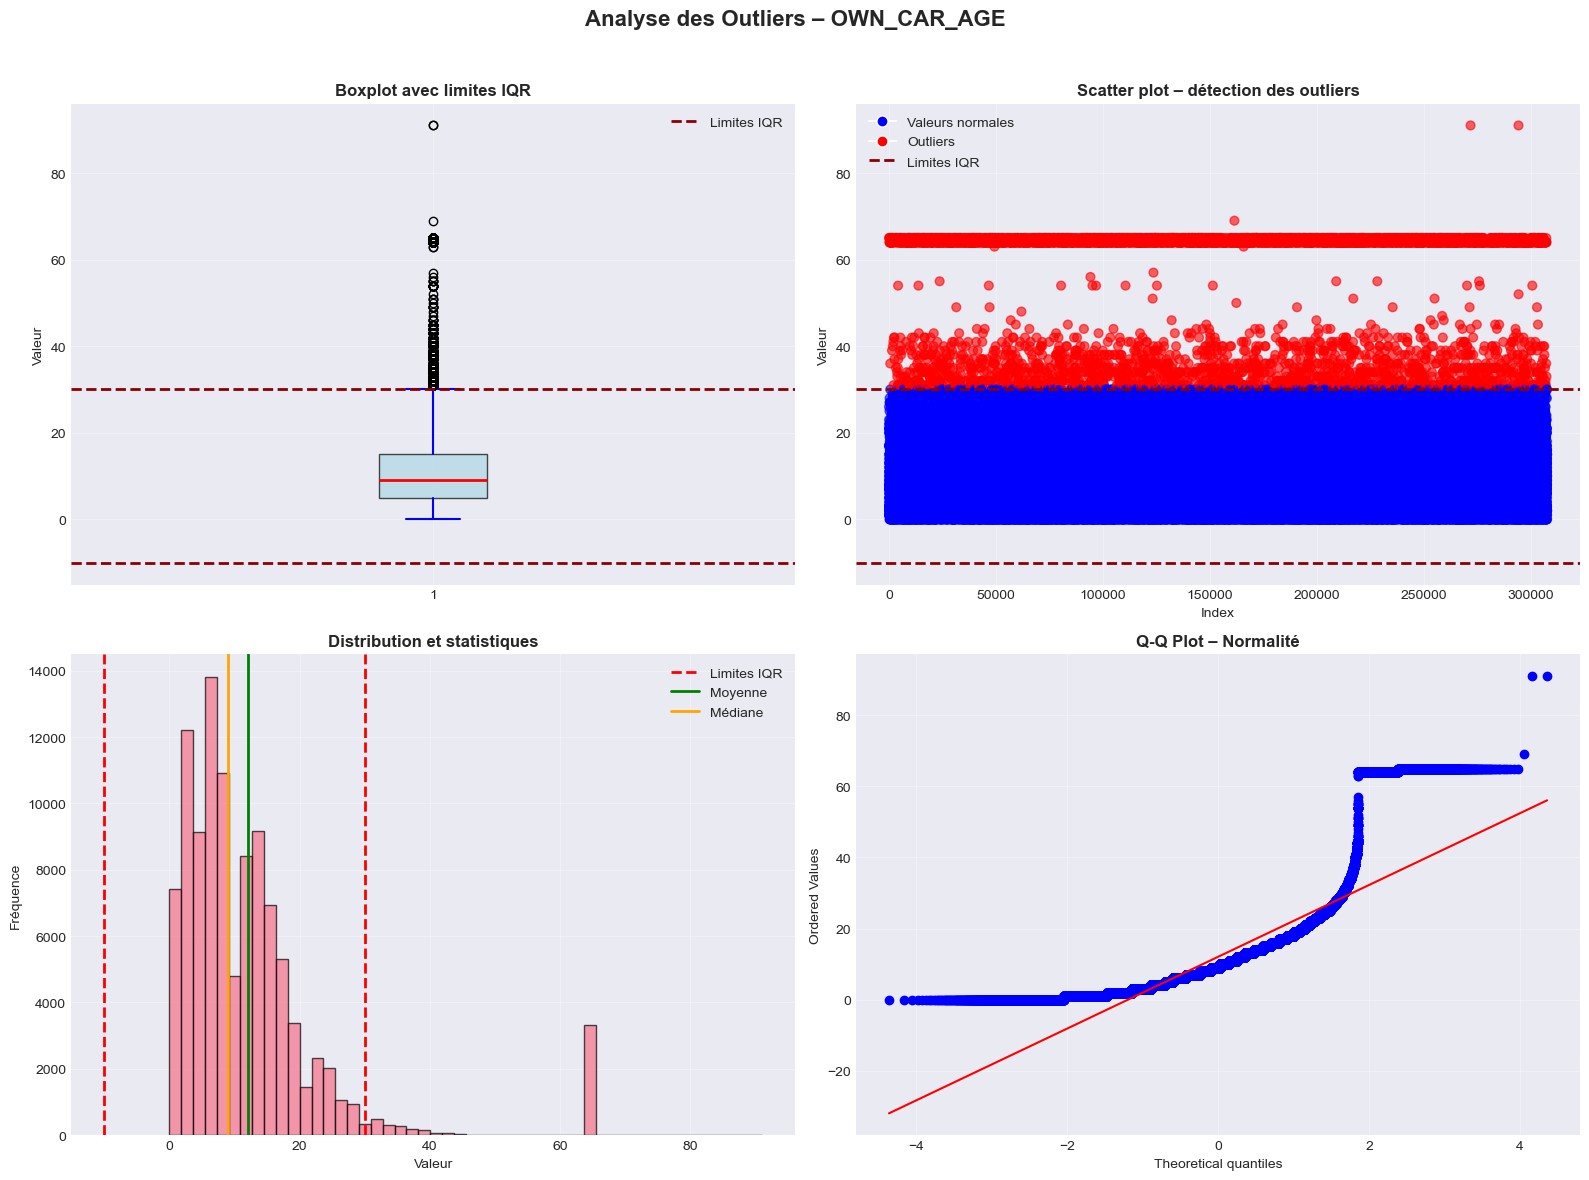


Résumé – OWN_CAR_AGE
  • Outliers détectés : 4932 (4.72 %)
  • < Limite inférieure : 0
  • > Limite supérieure : 4932

────────────────────────────────────────────────────────────────────────────────
Génération des graphiques pour : FLAG_MOBIL


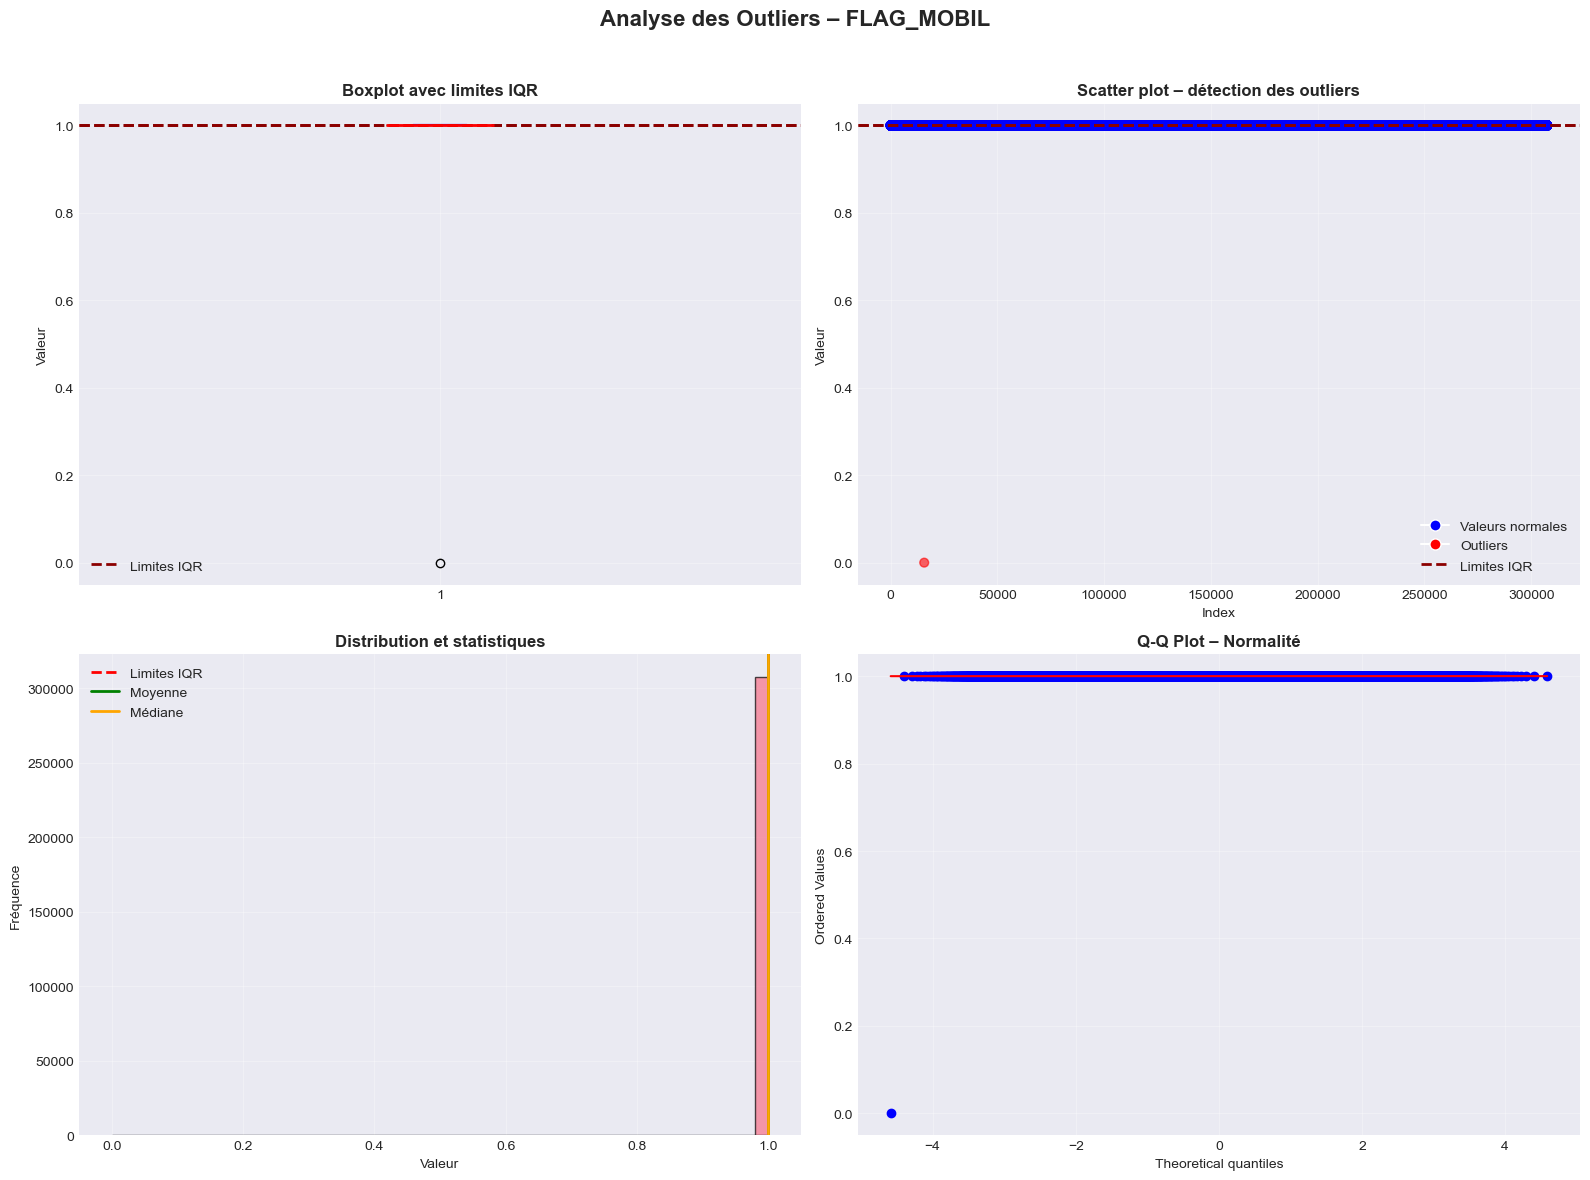


Résumé – FLAG_MOBIL
  • Outliers détectés : 1 (0.00 %)
  • < Limite inférieure : 1
  • > Limite supérieure : 0

────────────────────────────────────────────────────────────────────────────────
Génération des graphiques pour : FLAG_EMP_PHONE


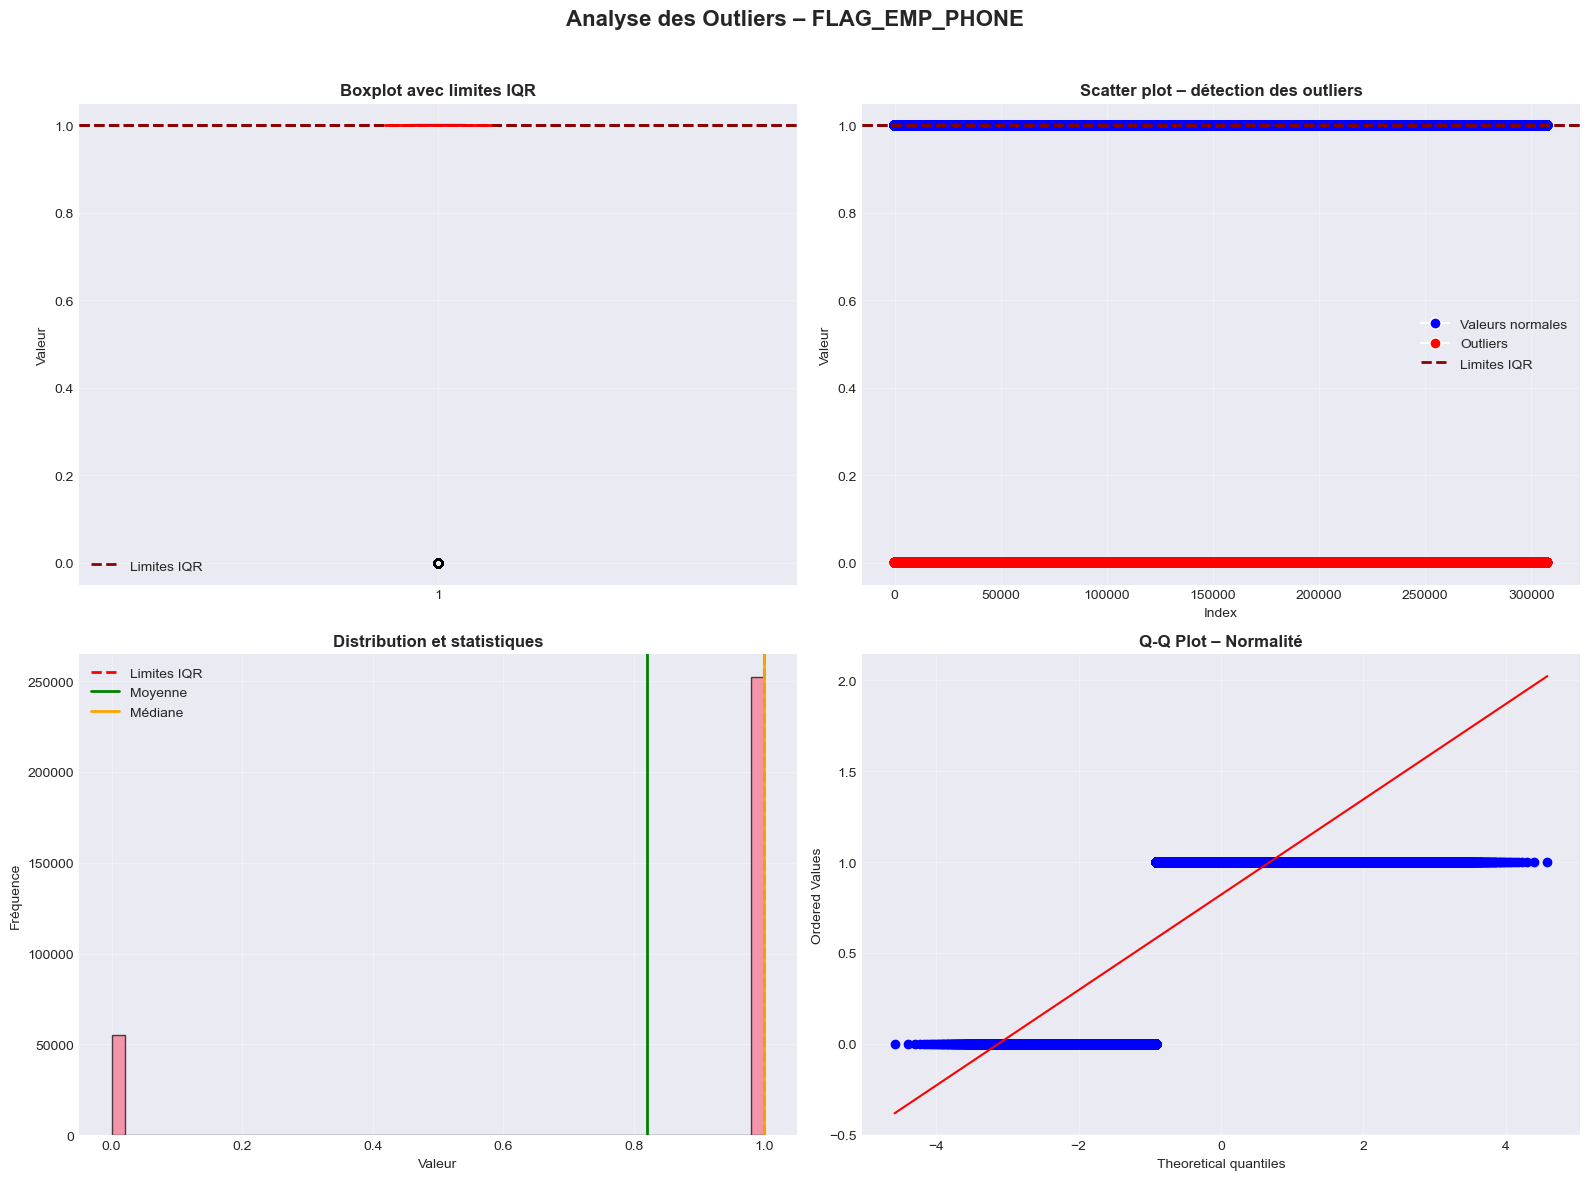


Résumé – FLAG_EMP_PHONE
  • Outliers détectés : 55386 (18.01 %)
  • < Limite inférieure : 55386
  • > Limite supérieure : 0


In [9]:
numeric_columns_15 = numeric_columns[:15]

import matplotlib.pyplot as plt
import scipy.stats as scistats
import numpy as np

def visualize_outliers_complete(data, column, outliers_mask, lower_bound, upper_bound):

    
    values = data[column]
    clean_values = values.dropna()
    mask = outliers_mask.loc[clean_values.index]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Analyse des Outliers – {column}', fontsize=16, fontweight='bold')

    # ─────────────────────────────────────────
    # 1. Boxplot
    # ─────────────────────────────────────────
    axes[0, 0].boxplot(
        clean_values,
        vert=True,
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', alpha=0.7),
        medianprops=dict(color='red', linewidth=2),
        whiskerprops=dict(color='blue', linewidth=1.5),
        capprops=dict(color='blue', linewidth=1.5)
    )

    axes[0, 0].axhline(lower_bound, color='darkred', linestyle='--', linewidth=2, label='Limites IQR')
    axes[0, 0].axhline(upper_bound, color='darkred', linestyle='--', linewidth=2)
    axes[0, 0].set_ylabel('Valeur')
    axes[0, 0].set_title('Boxplot avec limites IQR', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────
    # 2. Scatter plot (index vs valeur)
    # ─────────────────────────────────────────
    colors = np.where(mask, 'red', 'blue')

    axes[0, 1].scatter(
        clean_values.index,
        clean_values,
        c=colors,
        alpha=0.6,
        s=40
    )

    axes[0, 1].axhline(lower_bound, color='darkred', linestyle='--', linewidth=2)
    axes[0, 1].axhline(upper_bound, color='darkred', linestyle='--', linewidth=2)
    axes[0, 1].set_xlabel('Index')
    axes[0, 1].set_ylabel('Valeur')
    axes[0, 1].set_title('Scatter plot – détection des outliers', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # Légende manuelle (plus propre)
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Valeurs normales',
               markerfacecolor='blue', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Outliers',
               markerfacecolor='red', markersize=8),
        Line2D([0], [0], color='darkred', lw=2, linestyle='--', label='Limites IQR')
    ]
    axes[0, 1].legend(handles=legend_elements)

    # ─────────────────────────────────────────
    # 3. Histogramme + stats
    # ─────────────────────────────────────────
    axes[1, 0].hist(
        clean_values,
        bins=50,
        edgecolor='black',
        alpha=0.7
    )

    axes[1, 0].axvline(lower_bound, color='red', linestyle='--', linewidth=2, label='Limites IQR')
    axes[1, 0].axvline(upper_bound, color='red', linestyle='--', linewidth=2)
    axes[1, 0].axvline(clean_values.mean(), color='green', linewidth=2, label='Moyenne')
    axes[1, 0].axvline(clean_values.median(), color='orange', linewidth=2, label='Médiane')

    axes[1, 0].set_xlabel('Valeur')
    axes[1, 0].set_ylabel('Fréquence')
    axes[1, 0].set_title('Distribution et statistiques', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────
    # 4. Q-Q plot
    # ─────────────────────────────────────────
    scistats.probplot(clean_values, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot – Normalité', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # ─────────────────────────────────────────
    # Résumé chiffré
    # ─────────────────────────────────────────
    n_outliers = mask.sum()
    pct_outliers = 100 * n_outliers / len(clean_values)

    print(f"\nRésumé – {column}")
    print(f"  • Outliers détectés : {n_outliers} ({pct_outliers:.2f} %)")
    print(f"  • < Limite inférieure : {(clean_values < lower_bound).sum()}")
    print(f"  • > Limite supérieure : {(clean_values > upper_bound).sum()}")

for col in numeric_columns_15:
    print(f"\n{'─' * 80}")
    print(f"Génération des graphiques pour : {col}")

    visualize_outliers_complete(
        df,
        col,
        outliers_summary[col]['mask'],
        outliers_summary[col]['lower_bound'],
        outliers_summary[col]['upper_bound']
    )

### 6. MÉTHODES DE DÉTECTION ALTERNATIVES


COMPARAISON DES MÉTHODES DE DÉTECTION

                                                       Variable  IQR_outliers  IQR_%  Z-Score_outliers Z-Score_%  MAD_outliers  MAD_%
                                                     SK_ID_CURR             0  0.00%                 0     0.00%             0  0.00%
                                                         TARGET         24825  8.07%             24825     8.07%             0  0.00%
                                                   CNT_CHILDREN          4272  1.39%              4272     1.39%             0  0.00%
                                               AMT_INCOME_TOTAL         14035  4.56%               454     0.15%          9331  3.03%
                                                     AMT_CREDIT          6562  2.13%              3255     1.06%          3215  1.05%
                                                    AMT_ANNUITY          7504  2.44%              2959     0.96%             0  0.00%
                      

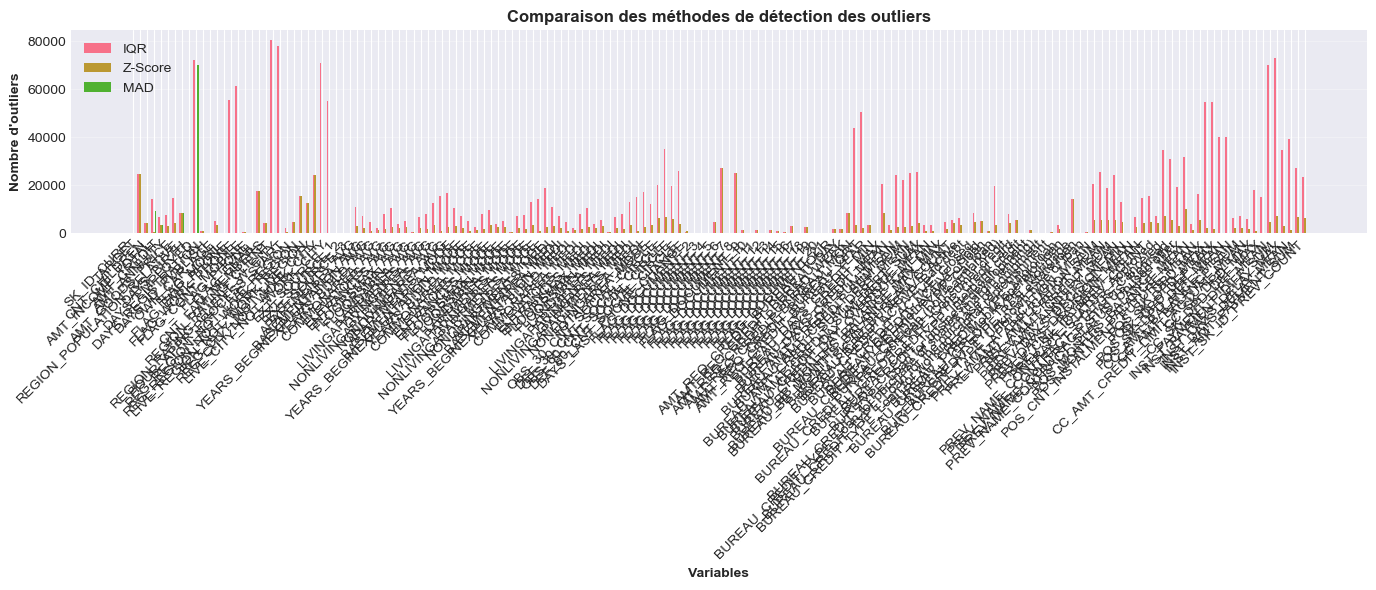

In [13]:
print("\n" + "=" * 80)
print("COMPARAISON DES MÉTHODES DE DÉTECTION")
print("=" * 80)

# Méthode Z-Score
def detect_outliers_zscore(data, column, threshold=3):
    """
    Détection des outliers par Z-Score (méthode classique)
    """
    values = data[column]

    z_scores = scistats.zscore(values.dropna())
    mask = pd.Series(False, index=values.index)

    mask.loc[values.dropna().index] = np.abs(z_scores) > threshold
    return mask

# Méthode MAD (Median Absolute Deviation)
def detect_outliers_mad(data, column, threshold=3.5):
    """
    Détection des outliers via le MAD (Modified Z-Score)
    Méthode robuste
    """
    values = data[column]
    median = values.median()
    mad = np.median(np.abs(values - median))

    if mad == 0 or np.isnan(mad):
        return pd.Series(False, index=values.index)

    modified_z_scores = 0.6745 * (values - median) / mad
    return np.abs(modified_z_scores) > threshold


# Comparaison des méthodes
comparison_results = []

for col in numeric_columns:
    iqr_outliers = outliers_summary[col]['mask'].sum()
    zscore_outliers = detect_outliers_zscore(df, col).sum()
    mad_outliers = detect_outliers_mad(df, col).sum()

    comparison_results.append({
        'Variable': col,
        'IQR_outliers': iqr_outliers,
        'IQR_%': f"{(iqr_outliers / len(df)) * 100:.2f}%",
        'Z-Score_outliers': zscore_outliers,
        'Z-Score_%': f"{(zscore_outliers / len(df)) * 100:.2f}%",
        'MAD_outliers': mad_outliers,
        'MAD_%': f"{(mad_outliers / len(df)) * 100:.2f}%"
    })

comparison_df = pd.DataFrame(comparison_results)
print("\n" + comparison_df.to_string(index=False))


# Visualisation comparative
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(numeric_columns))
width = 0.25

iqr_counts = comparison_df['IQR_outliers']
zscore_counts = comparison_df['Z-Score_outliers']
mad_counts = comparison_df['MAD_outliers']

ax.bar(x - width, iqr_counts, width, label='IQR')
ax.bar(x, zscore_counts, width, label='Z-Score')
ax.bar(x + width, mad_counts, width, label='MAD')

ax.set_xlabel('Variables', fontweight='bold')
ax.set_ylabel("Nombre d'outliers", fontweight='bold')
ax.set_title('Comparaison des méthodes de détection des outliers', fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(numeric_columns, rotation=45, ha='right')

ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



### 7. TRAITEMENT DES OUTLIERS - WINSORISATION


────────────────────────────────────────────────────────────────────────────────

Winsorisation appliquée sur: SK_ID_CURR
  Limites: 5.0% - 95.0%

  Avant winsorisation:
    Min: 100002.00
    Max: 456255.00
    Moyenne: 278180.52
    Écart-type: 102790.18

  Après winsorisation:
    Min: 117945.00
    Max: 438428.00
    Moyenne: 278183.07
    Écart-type: 101331.68

  Valeurs modifiées: 30750 (10.00%)

────────────────────────────────────────────────────────────────────────────────

Winsorisation appliquée sur: TARGET
  Limites: 5.0% - 95.0%

  Avant winsorisation:
    Min: 0.00
    Max: 1.00
    Moyenne: 0.08
    Écart-type: 0.27

  Après winsorisation:
    Min: 0.00
    Max: 1.00
    Moyenne: 0.08
    Écart-type: 0.27

  Valeurs modifiées: 0 (0.00%)

────────────────────────────────────────────────────────────────────────────────

Winsorisation appliquée sur: CNT_CHILDREN
  Limites: 5.0% - 95.0%

  Avant winsorisation:
    Min: 0.00
    Max: 19.00
    Moyenne: 0.42
    Écart-type: 0

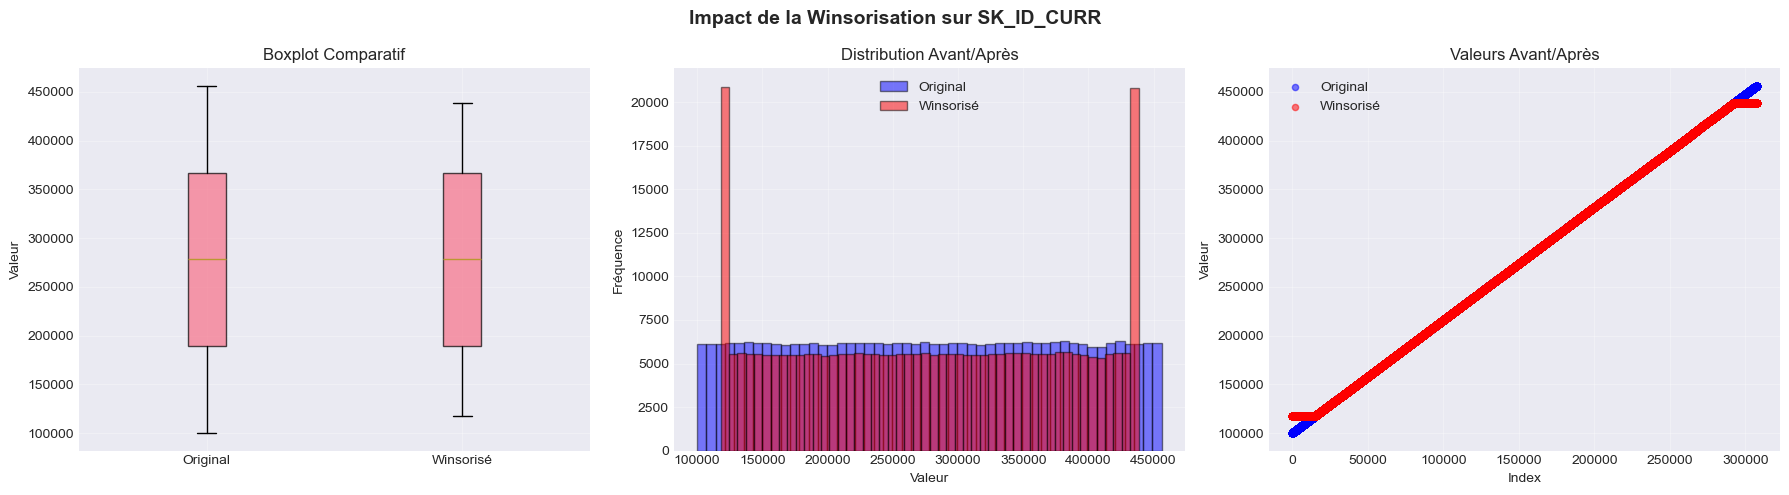

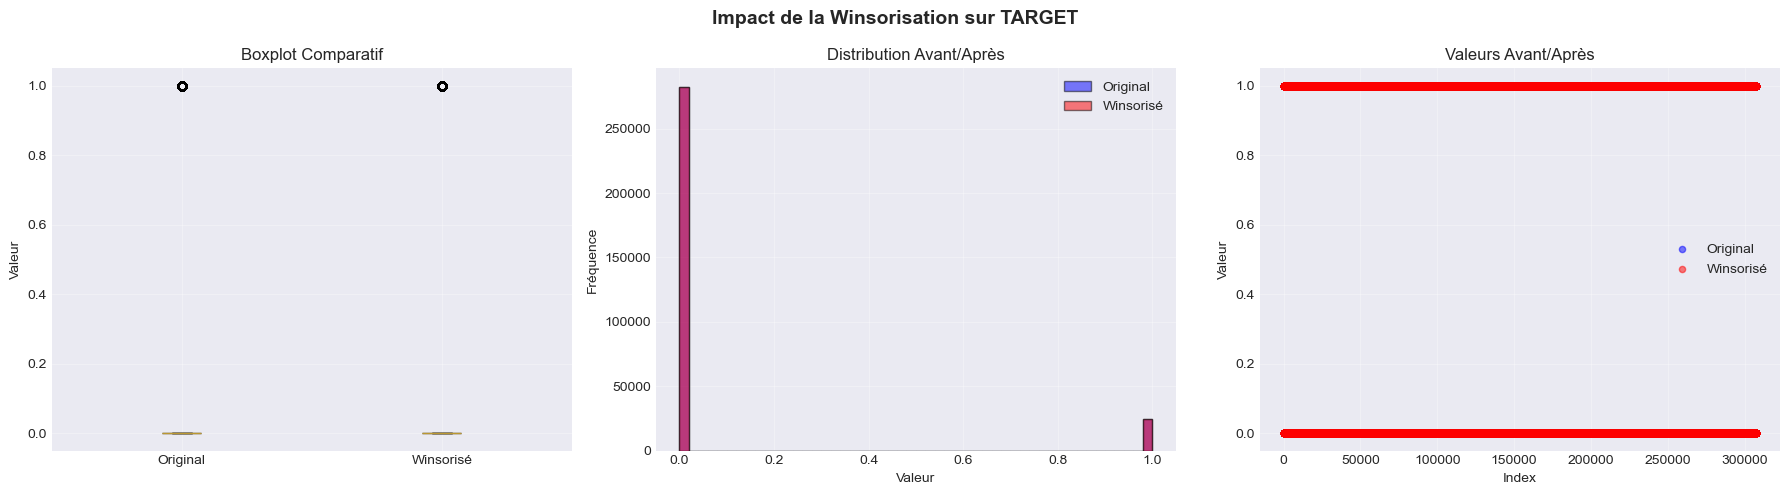

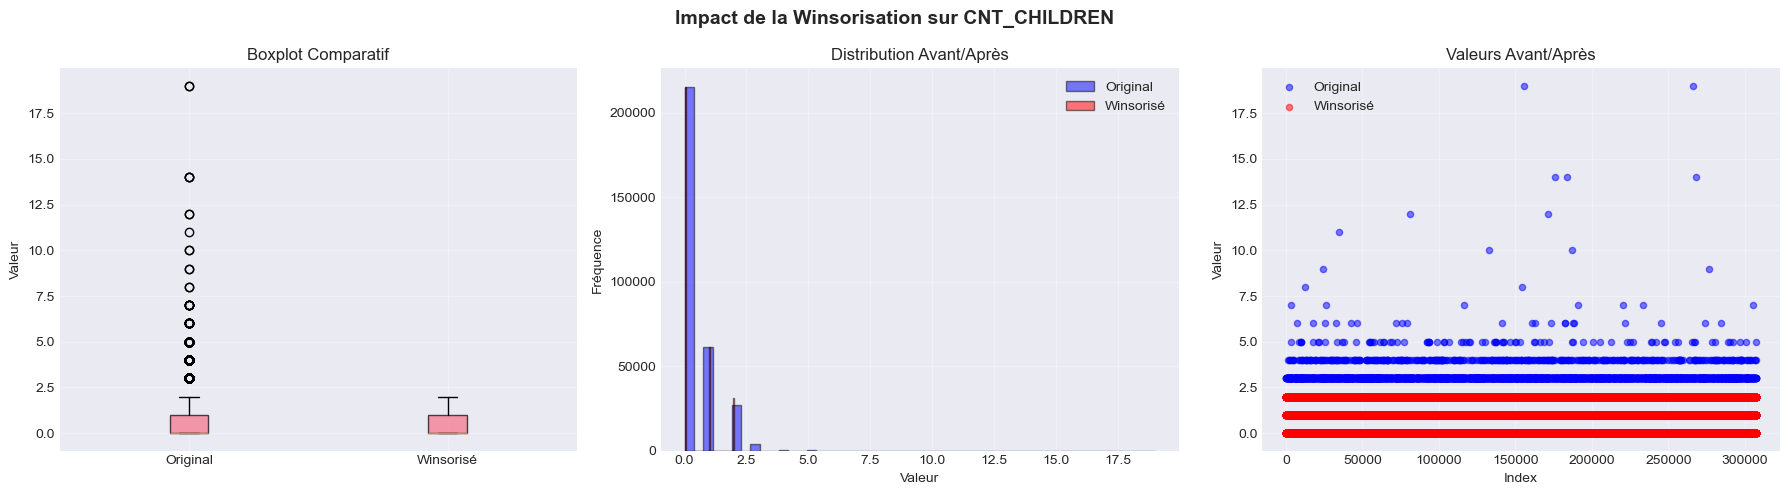

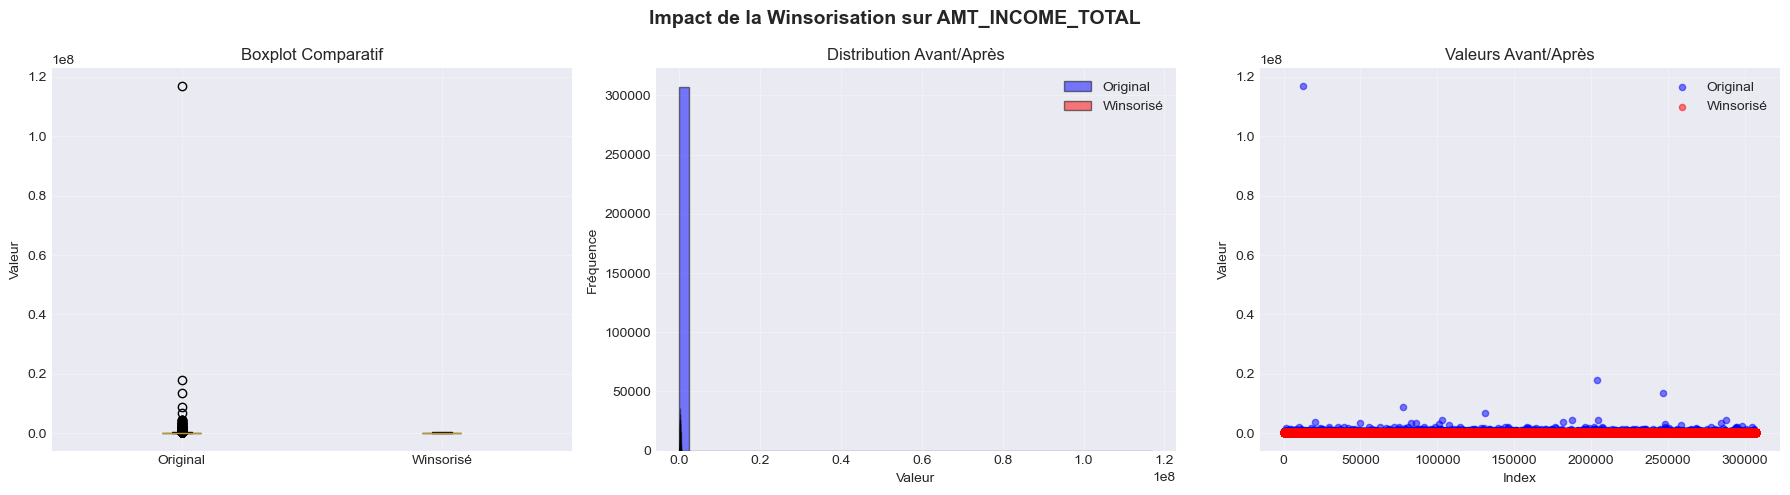

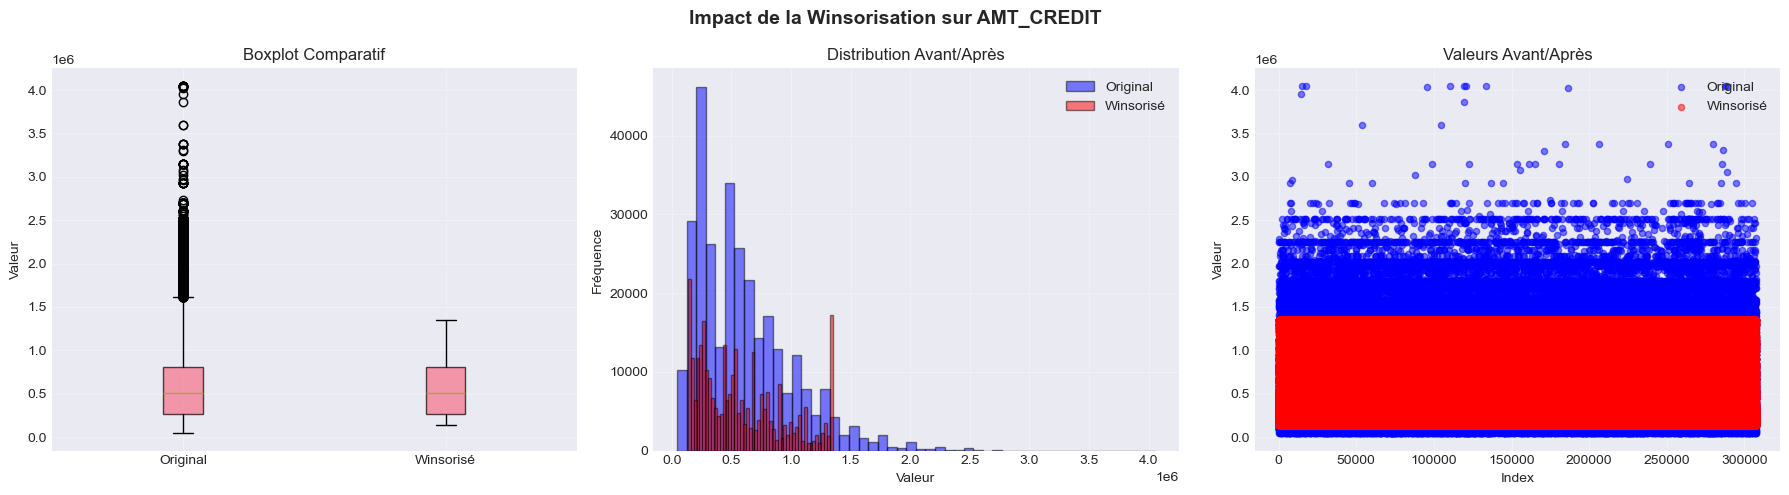

In [17]:


def apply_winsorization(data, column, limits=(0.05, 0.05)):
    """
    Applique la winsorisation sur une colonne
    
    Paramètres:
    -----------
    limits : tuple - percentiles à limiter (inférieur, supérieur)
                     Par exemple (0.05, 0.05) = 5% et 95%
    """
    data_copy = data.copy()
    winsorized_values = winsorize(data[column], limits=limits)
    data_copy[f'{column}_winsorized'] = winsorized_values
    
    # Statistiques avant/après
    print(f"\nWinsorisation appliquée sur: {column}")
    print(f"  Limites: {limits[0]*100}% - {(1-limits[1])*100}%")
    print(f"\n  Avant winsorisation:")
    print(f"    Min: {data[column].min():.2f}")
    print(f"    Max: {data[column].max():.2f}")
    print(f"    Moyenne: {data[column].mean():.2f}")
    print(f"    Écart-type: {data[column].std():.2f}")
    
    print(f"\n  Après winsorisation:")
    print(f"    Min: {data_copy[f'{column}_winsorized'].min():.2f}")
    print(f"    Max: {data_copy[f'{column}_winsorized'].max():.2f}")
    print(f"    Moyenne: {data_copy[f'{column}_winsorized'].mean():.2f}")
    print(f"    Écart-type: {data_copy[f'{column}_winsorized'].std():.2f}")
    
    n_modified = (data[column] != data_copy[f'{column}_winsorized']).sum()
    print(f"\n  Valeurs modifiées: {n_modified} ({(n_modified/len(data))*100:.2f}%)")
    
    return data_copy

# Application de la winsorisation sur toutes les variables
df_winsorized = df.copy()
for col in numeric_columns:
    print(f"\n{'─' * 80}")
    df_winsorized = apply_winsorization(df_winsorized, col, limits=(0.05, 0.05))

# Limiter les visualisations aux 5 premières variables
for col in numeric_columns[:5]:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Impact de la Winsorisation sur {col}', fontsize=14, fontweight='bold')
    
    # Boxplot comparatif
    data_to_plot = [df[col].dropna(), df_winsorized[f'{col}_winsorized'].dropna()]
    axes[0].boxplot(data_to_plot, labels=['Original', 'Winsorisé'], patch_artist=True,
                    boxprops=dict(alpha=0.7))
    axes[0].set_ylabel('Valeur')
    axes[0].set_title('Boxplot Comparatif')
    axes[0].grid(True, alpha=0.3)
    
    # Histogrammes superposés
    axes[1].hist(df[col].dropna(), bins=50, alpha=0.5, label='Original', color='blue', edgecolor='black')
    axes[1].hist(df_winsorized[f'{col}_winsorized'].dropna(), bins=50, alpha=0.5, label='Winsorisé', color='red', edgecolor='black')
    axes[1].set_xlabel('Valeur')
    axes[1].set_ylabel('Fréquence')
    axes[1].set_title('Distribution Avant/Après')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Scatter plot avant/après
    indices = range(len(df))
    axes[2].scatter(indices, df[col], alpha=0.5, s=20, label='Original', color='blue')
    axes[2].scatter(indices, df_winsorized[f'{col}_winsorized'], alpha=0.5, s=20, label='Winsorisé', color='red')
    axes[2].set_xlabel('Index')
    axes[2].set_ylabel('Valeur')
    axes[2].set_title('Valeurs Avant/Après')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 8. TRAITEMENT DES OUTLIERS - CAPPING


TRAITEMENT DES OUTLIERS - MÉTHODE 2: CAPPING

────────────────────────────────────────────────────────────────────────────────

Capping appliqué sur: SK_ID_CURR
  Percentiles: 5% - 95%
  Limite inférieure: 117945.50
  Limite supérieure: 438427.50

  Valeurs plafonnées (total): 30752 (10.00%)
    - En-dessous du seuil inf: 15376
    - Au-dessus du seuil sup: 15376

────────────────────────────────────────────────────────────────────────────────

Capping appliqué sur: TARGET
  Percentiles: 5% - 95%
  Limite inférieure: 0.00
  Limite supérieure: 1.00

  Valeurs plafonnées (total): 0 (0.00%)
    - En-dessous du seuil inf: 0
    - Au-dessus du seuil sup: 0

────────────────────────────────────────────────────────────────────────────────

Capping appliqué sur: CNT_CHILDREN
  Percentiles: 5% - 95%
  Limite inférieure: 0.00
  Limite supérieure: 2.00

  Valeurs plafonnées (total): 4272 (1.39%)
    - En-dessous du seuil inf: 0
    - Au-dessus du seuil sup: 4272

────────────────────────────────

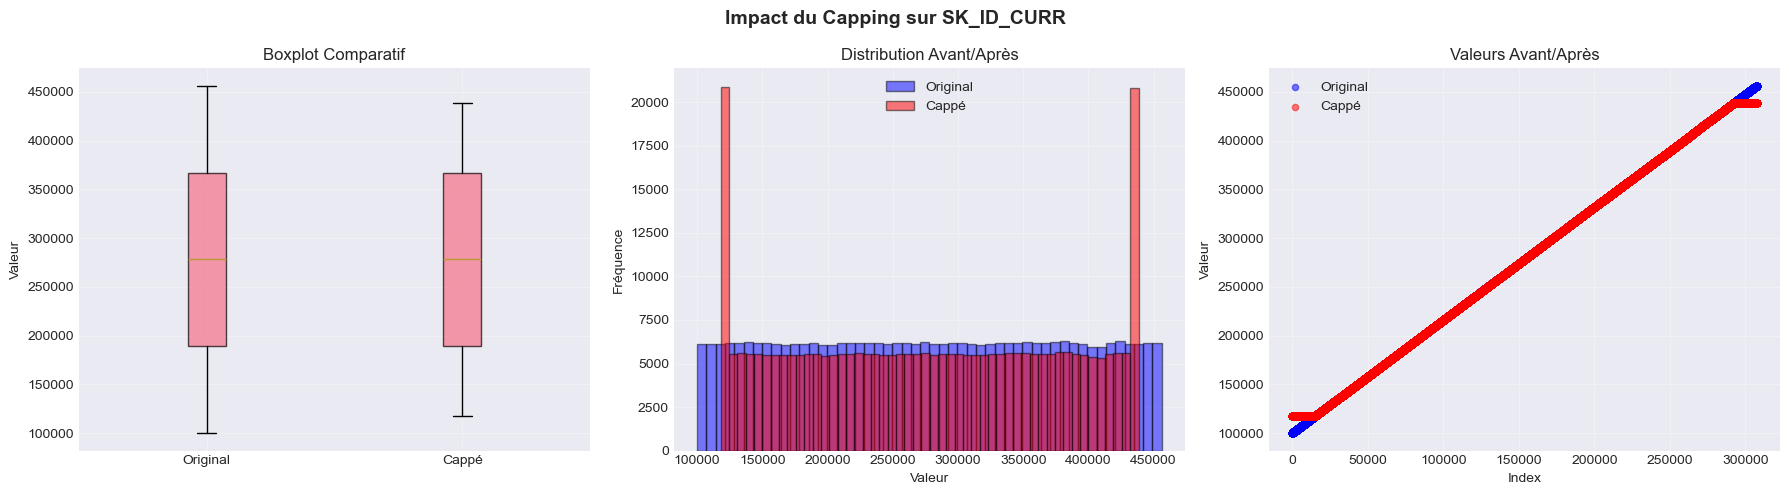

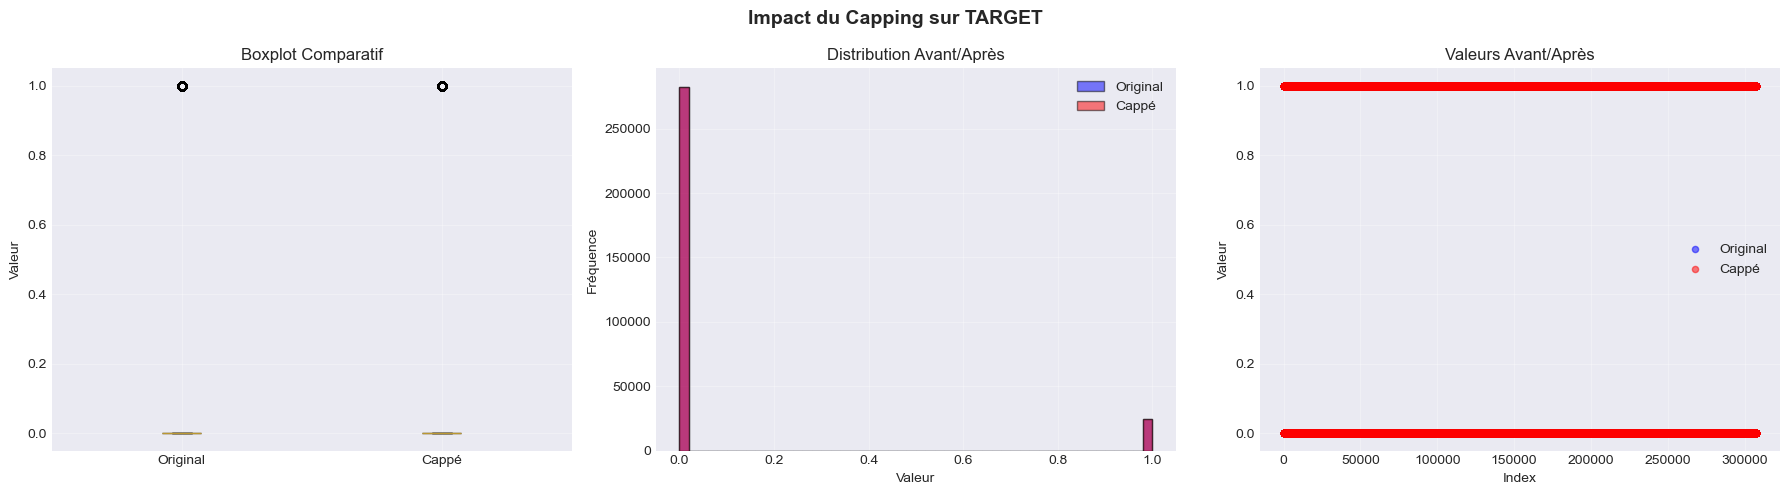

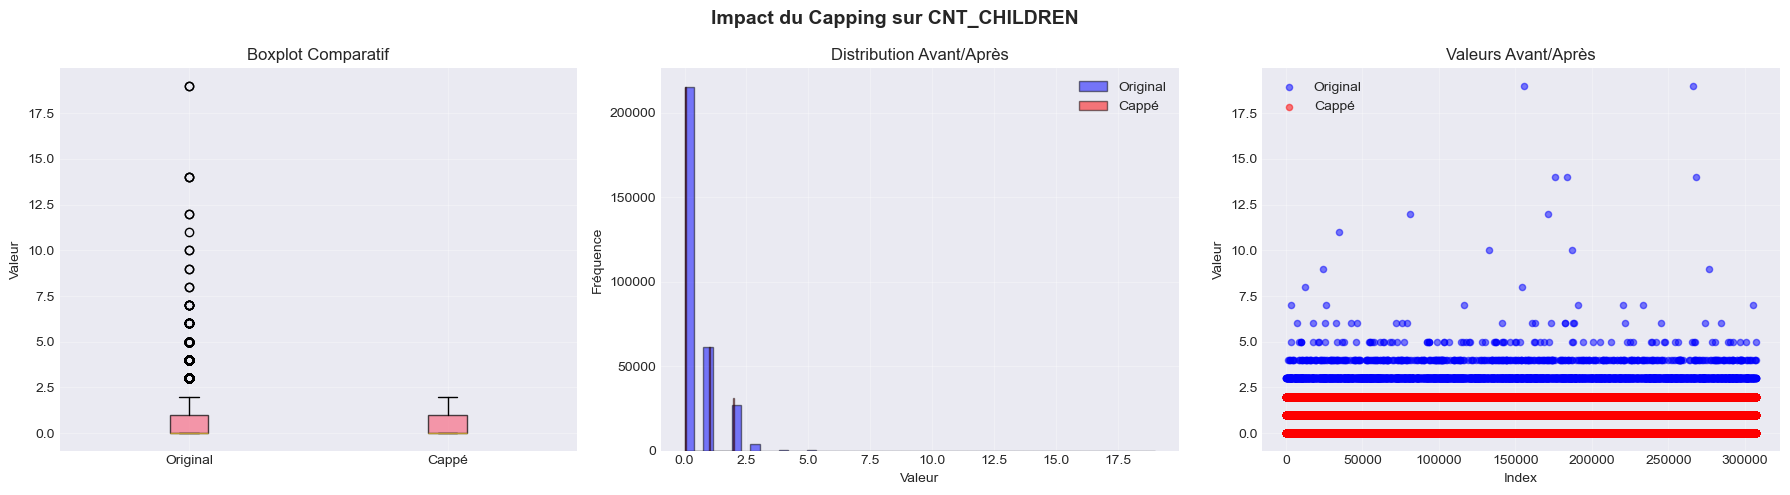

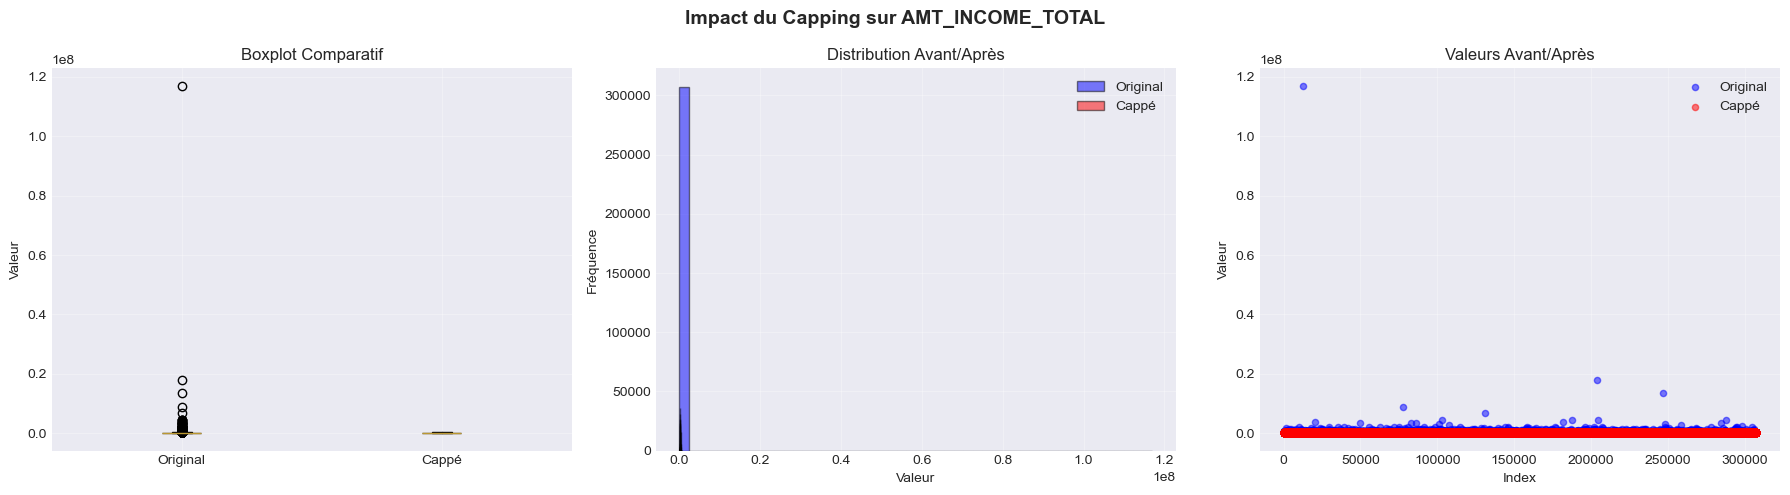

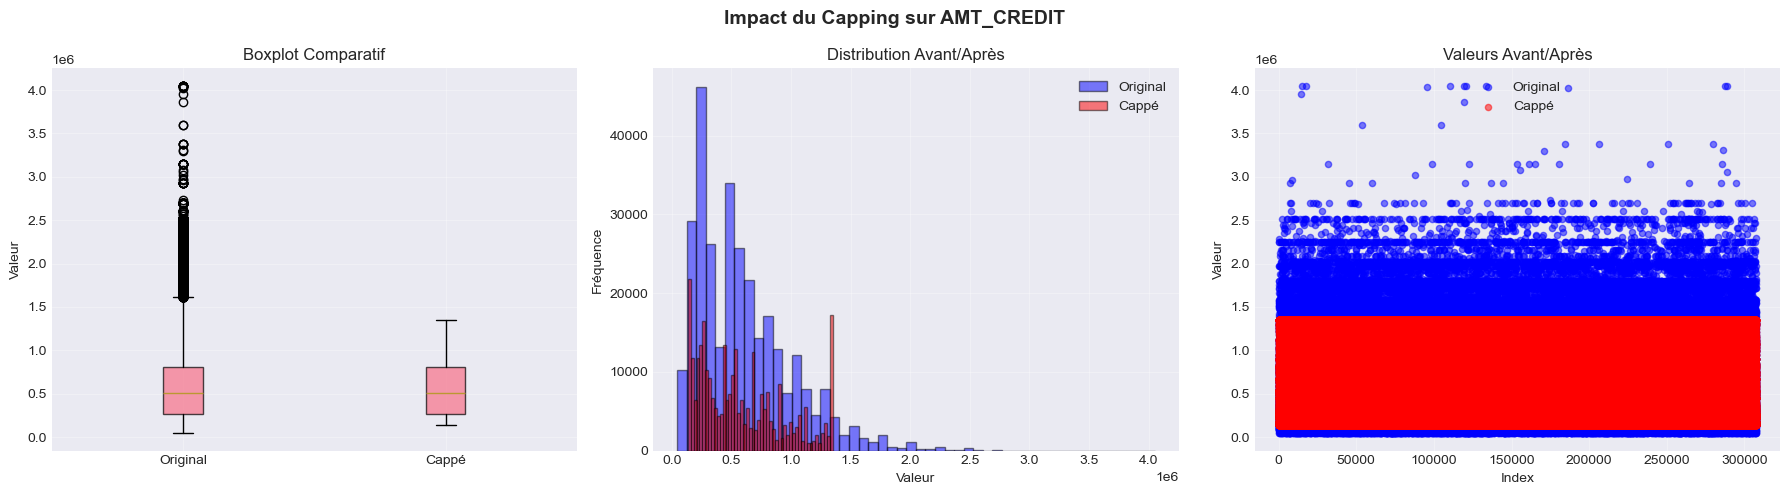

In [18]:
print("\n" + "=" * 80)
print("TRAITEMENT DES OUTLIERS - MÉTHODE 2: CAPPING")
print("=" * 80)

def apply_capping(data, column, lower_percentile=5, upper_percentile=95):
    """
    Limite les valeurs aux percentiles spécifiés
    """
    data_copy = data.copy()
    lower_cap = data[column].quantile(lower_percentile/100)
    upper_cap = data[column].quantile(upper_percentile/100)
    
    data_copy[f'{column}_capped'] = data[column].clip(lower=lower_cap, upper=upper_cap)
    
    n_capped_lower = (data[column] < lower_cap).sum()
    n_capped_upper = (data[column] > upper_cap).sum()
    n_capped_total = n_capped_lower + n_capped_upper
    
    print(f"\nCapping appliqué sur: {column}")
    print(f"  Percentiles: {lower_percentile}% - {upper_percentile}%")
    print(f"  Limite inférieure: {lower_cap:.2f}")
    print(f"  Limite supérieure: {upper_cap:.2f}")
    print(f"\n  Valeurs plafonnées (total): {n_capped_total} ({(n_capped_total/len(data))*100:.2f}%)")
    print(f"    - En-dessous du seuil inf: {n_capped_lower}")
    print(f"    - Au-dessus du seuil sup: {n_capped_upper}")
    
    return data_copy

# Application du capping
df_capped = df.copy()

for col in numeric_columns:
    print(f"\n{'─' * 80}")
    df_capped = apply_capping(df_capped, col, lower_percentile=5, upper_percentile=95)
# Visualisation avant/après capping pour les 5 premières variables
for col in numeric_columns[:5]:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Impact du Capping sur {col}', fontsize=14, fontweight='bold')
    
    # Boxplot comparatif
    data_to_plot = [df[col].dropna(), df_capped[f'{col}_capped'].dropna()]
    axes[0].boxplot(data_to_plot, labels=['Original', 'Cappé'], patch_artist=True,
                    boxprops=dict(alpha=0.7))
    axes[0].set_ylabel('Valeur')
    axes[0].set_title('Boxplot Comparatif')
    axes[0].grid(True, alpha=0.3)
    
    # Histogrammes superposés
    axes[1].hist(df[col].dropna(), bins=50, alpha=0.5, label='Original', color='blue', edgecolor='black')
    axes[1].hist(df_capped[f'{col}_capped'].dropna(), bins=50, alpha=0.5, label='Cappé', color='red', edgecolor='black')
    axes[1].set_xlabel('Valeur')
    axes[1].set_ylabel('Fréquence')
    axes[1].set_title('Distribution Avant/Après')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Scatter plot avant/après
    indices = range(len(df))
    axes[2].scatter(indices, df[col], alpha=0.5, s=20, label='Original', color='blue')
    axes[2].scatter(indices, df_capped[f'{col}_capped'], alpha=0.5, s=20, label='Cappé', color='red')
    axes[2].set_xlabel('Index')
    axes[2].set_ylabel('Valeur')
    axes[2].set_title('Valeurs Avant/Après')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


### 9. TRAITEMENT DES OUTLIERS - TRANSFORMATION LOGARITHMIQUE


TRAITEMENT DES OUTLIERS - MÉTHODE 3: TRANSFORMATION LOGARITHMIQUE

Transformation log appliquée sur: SK_ID_CURR
  Skewness: Avant=-0.001, Après=-0.521, Amélioration=False
  Kurtosis: Avant=-1.199, Après=-0.821
  Statistiques: Min/Max Avant=(100002.00/456255.00), Après=(11.51/13.03)

Transformation log appliquée sur: TARGET
  Skewness: Avant=3.078, Après=3.078, Amélioration=True
  Kurtosis: Avant=7.475, Après=7.475
  Statistiques: Min/Max Avant=(0.00/1.00), Après=(0.00/0.69)

Transformation log appliquée sur: CNT_CHILDREN
  Skewness: Avant=1.975, Après=1.215, Amélioration=True
  Kurtosis: Avant=7.904, Après=0.061
  Statistiques: Min/Max Avant=(0.00/19.00), Après=(0.00/3.00)

Transformation log appliquée sur: AMT_INCOME_TOTAL
  Skewness: Avant=391.560, Après=0.170, Amélioration=True
  Kurtosis: Avant=191786.554, Après=0.751
  Statistiques: Min/Max Avant=(25650.00/117000000.00), Après=(10.15/18.58)

Transformation log appliquée sur: AMT_CREDIT
  Skewness: Avant=1.235, Après=-0.339, Améli

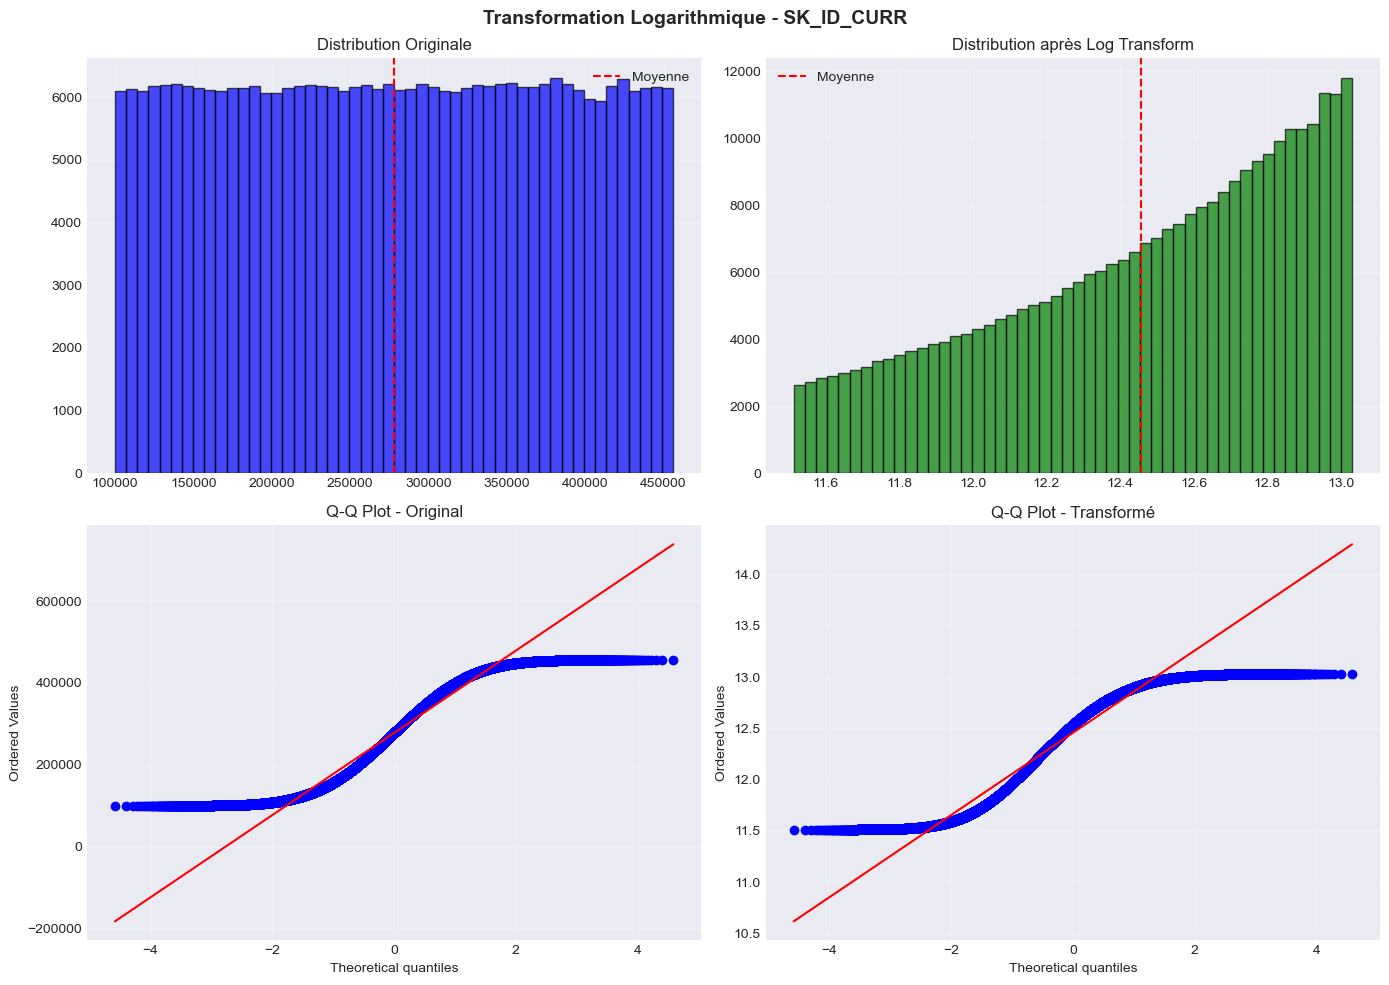

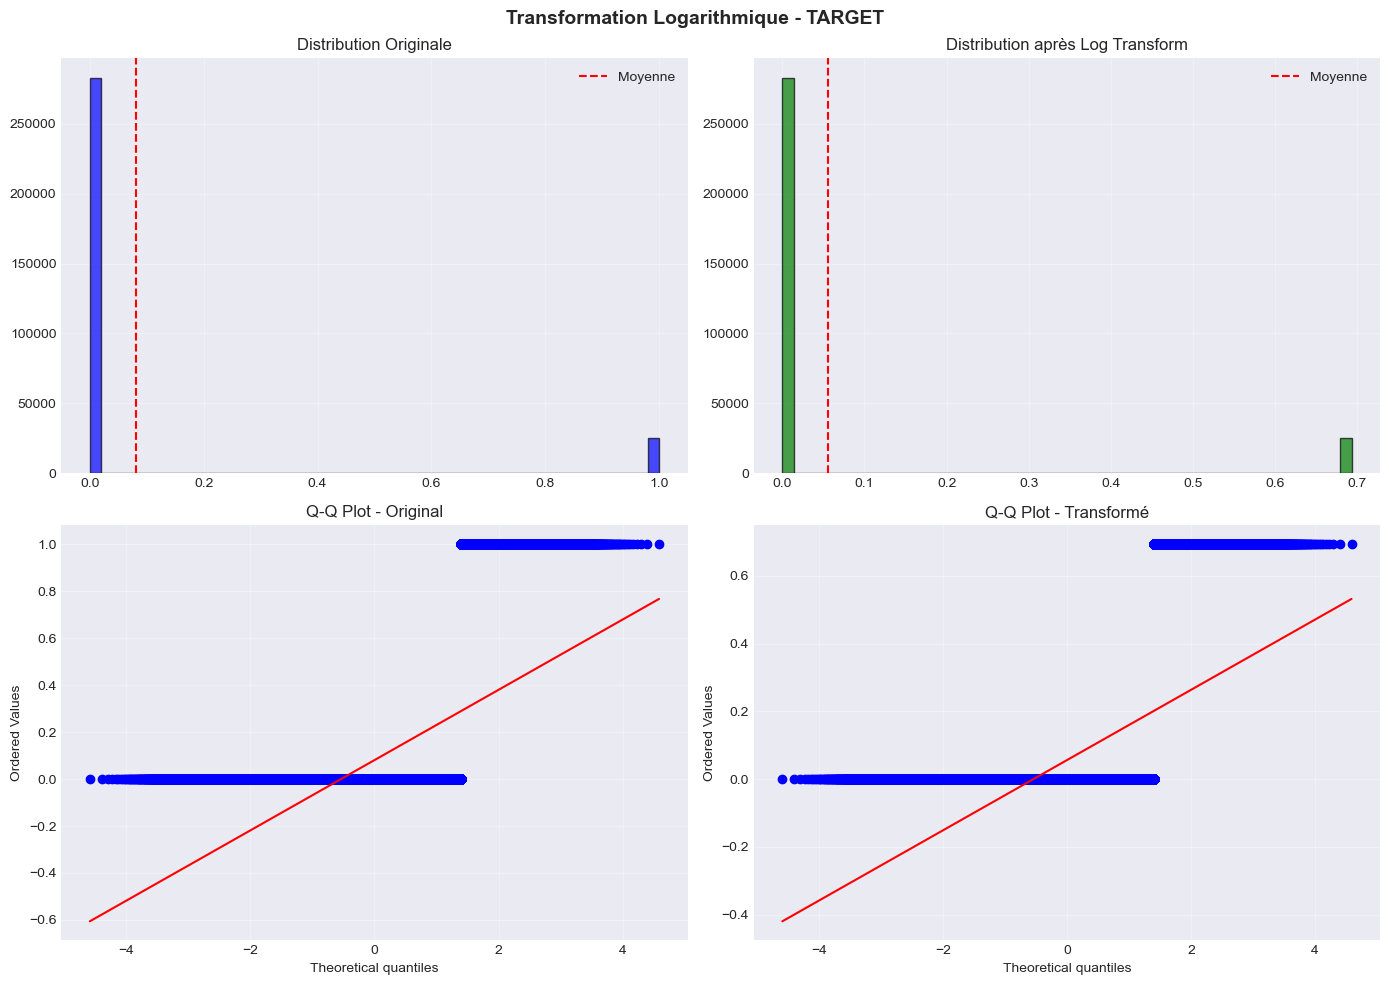

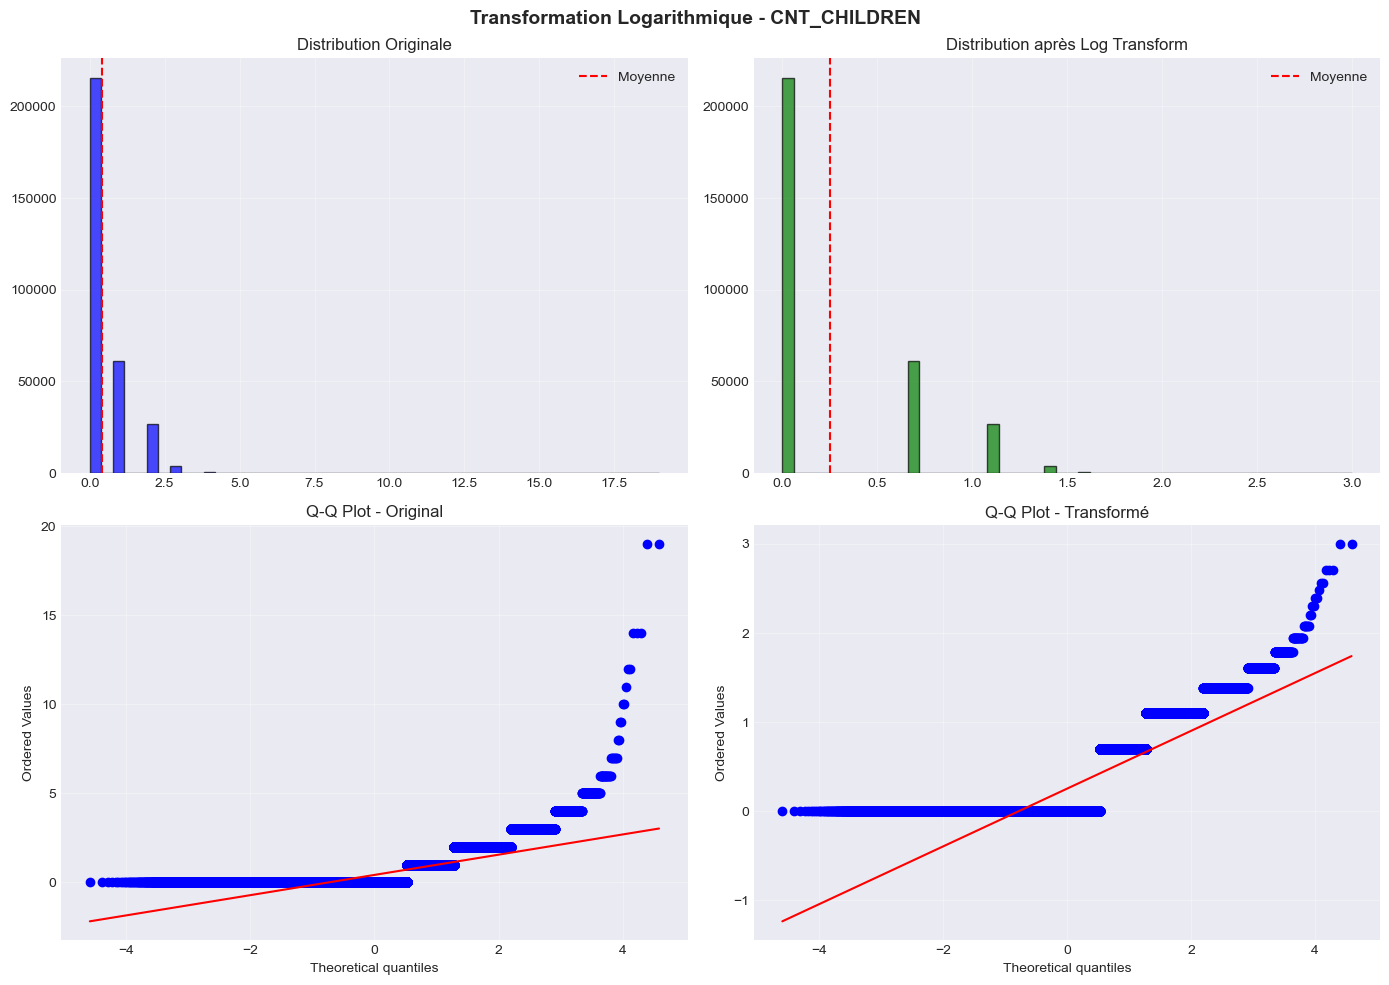

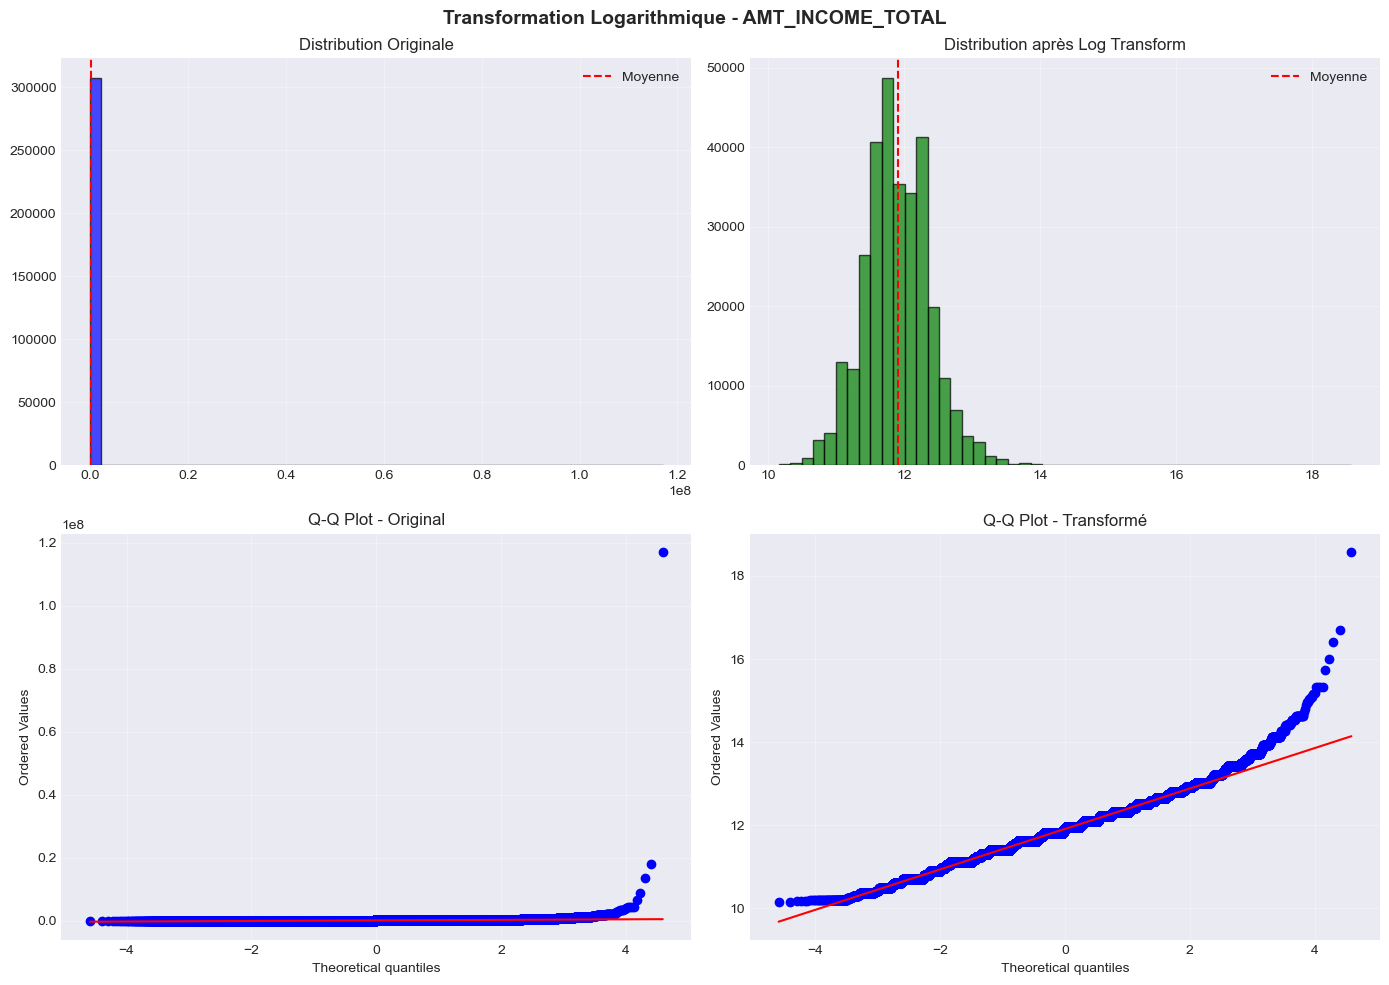

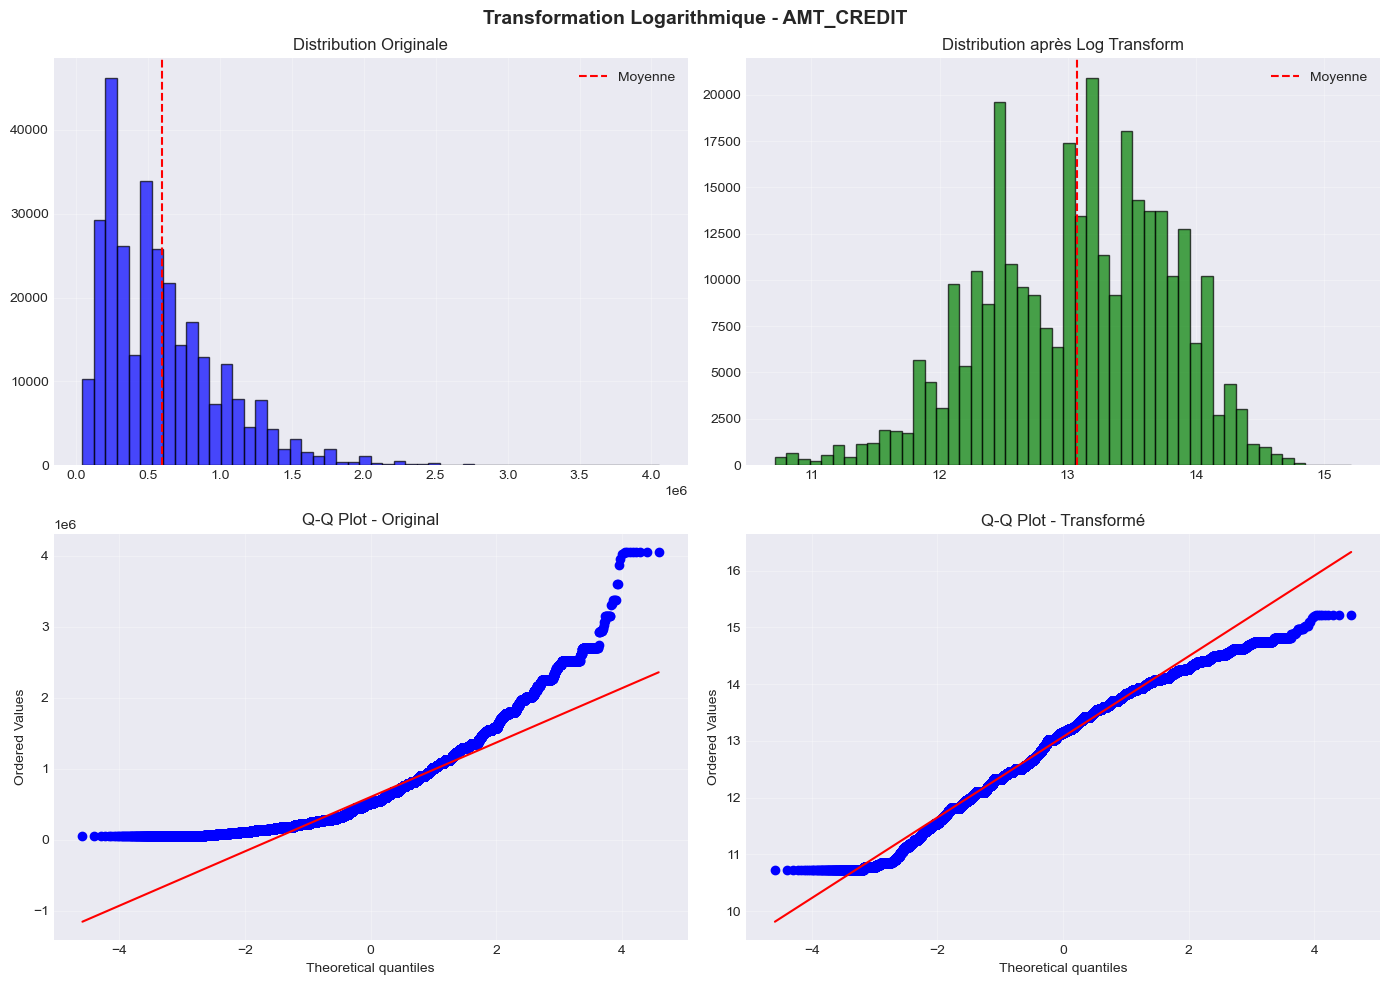

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sstats

print("\n" + "=" * 80)
print("TRAITEMENT DES OUTLIERS - MÉTHODE 3: TRANSFORMATION LOGARITHMIQUE")
print("=" * 80)

def apply_log_transform(data, column):
    data_copy = data.copy()
    
    if (data[column] < 0).any():
        print(f"\nATTENTION: {column} contient des valeurs négatives! Transformation log ignorée.")
        return data_copy
    
    data_copy[f'{column}_log'] = np.log1p(data[column])
    
    skew_before = data[column].skew()
    skew_after = data_copy[f'{column}_log'].skew()
    kurt_before = data[column].kurtosis()
    kurt_after = data_copy[f'{column}_log'].kurtosis()
    
    print(f"\nTransformation log appliquée sur: {column}")
    print(f"  Skewness: Avant={skew_before:.3f}, Après={skew_after:.3f}, Amélioration={abs(skew_after)<abs(skew_before)}")
    print(f"  Kurtosis: Avant={kurt_before:.3f}, Après={kurt_after:.3f}")
    
    print(f"  Statistiques: Min/Max Avant=({data[column].min():.2f}/{data[column].max():.2f}), "
          f"Après=({data_copy[f'{column}_log'].min():.2f}/{data_copy[f'{column}_log'].max():.2f})")
    
    return data_copy

# -----------------------------
# Appliquer log sur toutes les variables
# -----------------------------
df_log = df.copy()
for col in numeric_columns:
    df_log = apply_log_transform(df_log, col)

# -----------------------------
# Visualiser seulement les 5 premières variables
# -----------------------------
for col in numeric_columns[:5]:
    if f'{col}_log' in df_log.columns:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f'Transformation Logarithmique - {col}', fontsize=14, fontweight='bold')
        
        # Histogramme avant
        axes[0, 0].hist(df[col].dropna(), bins=50, alpha=0.7, color='blue', edgecolor='black')
        axes[0, 0].set_title('Distribution Originale')
        axes[0, 0].axvline(df[col].mean(), color='red', linestyle='--', label='Moyenne')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Histogramme après
        axes[0, 1].hist(df_log[f'{col}_log'].dropna(), bins=50, alpha=0.7, color='green', edgecolor='black')
        axes[0, 1].set_title('Distribution après Log Transform')
        axes[0, 1].axvline(df_log[f'{col}_log'].mean(), color='red', linestyle='--', label='Moyenne')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Q-Q plot avant
        sstats.probplot(df[col].dropna(), dist="norm", plot=axes[1,0])
        axes[1,0].set_title('Q-Q Plot - Original')
        axes[1,0].grid(True, alpha=0.3)
        
        # Q-Q plot après
        sstats.probplot(df_log[f'{col}_log'].dropna(), dist="norm", plot=axes[1,1])
        axes[1,1].set_title('Q-Q Plot - Transformé')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


### 10. TRAITEMENT DES OUTLIERS - SUPPRESSION

In [24]:
print("\n" + "=" * 80)
print("TRAITEMENT DES OUTLIERS - MÉTHODE 4: SUPPRESSION")
print("=" * 80)

def remove_outliers_iqr(data, columns):
    """
    Supprime les lignes contenant des outliers
    """
    data_copy = data.copy()
    initial_size = len(data_copy)
    
    # Créer un masque combiné pour tous les outliers
    combined_mask = pd.Series(False, index=data_copy.index)
    
    outliers_by_column = {}
    
    for col in columns:
        mask, _, _, _ = detect_outliers_iqr(data_copy, col)
        outliers_by_column[col] = mask.sum()
        combined_mask = combined_mask | mask
    
    # Suppression des outliers
    data_clean = data_copy[~combined_mask]
    removed = initial_size - len(data_clean)
    
    print(f"\nSuppression des outliers:")
    print(f"  Taille initiale: {initial_size}")
    print(f"  Lignes supprimées: {removed} ({(removed/initial_size)*100:.2f}%)")
    print(f"  Taille finale: {len(data_clean)}")
    
    print(f"\n  Répartition des outliers par variable:")
    for col, count in outliers_by_column.items():
        print(f"    {col}: {count} outliers")
    
    return data_clean

# Application de la suppression
df_clean = remove_outliers_iqr(df, numeric_columns)

# Comparaison des distributions avant/après suppression
fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(14, 5*len(numeric_columns)))
if len(numeric_columns) == 1:
    axes = axes.reshape(1, -1)

fig.suptitle('Comparaison des distributions - Avant/Après suppression des outliers', 
             fontsize=16, fontweight='bold')

for idx, col in enumerate(numeric_columns[:5]):  # Limiter à 5 pour la visualisation
    # Avant
    axes[idx, 0].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
    axes[idx, 0].set_title(f'{col} - Avec outliers (n={len(df)})')
    axes[idx, 0].set_xlabel('Valeur')
    axes[idx, 0].set_ylabel('Fréquence')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Après
    axes[idx, 1].hist(df_clean[col].dropna(), bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
    axes[idx, 1].set_title(f'{col} - Sans outliers (n={len(df_clean)})')
    axes[idx, 1].set_xlabel('Valeur')
    axes[idx, 1].set_ylabel('Fréquence')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


TRAITEMENT DES OUTLIERS - MÉTHODE 4: SUPPRESSION

Suppression des outliers:
  Taille initiale: 307511
  Lignes supprimées: 299146 (97.28%)
  Taille finale: 8365

  Répartition des outliers par variable:
    SK_ID_CURR: 0 outliers
    TARGET: 24825 outliers
    CNT_CHILDREN: 4272 outliers
    AMT_INCOME_TOTAL: 14035 outliers
    AMT_CREDIT: 6562 outliers
    AMT_ANNUITY: 7504 outliers
    AMT_GOODS_PRICE: 14728 outliers
    REGION_POPULATION_RELATIVE: 8412 outliers
    DAYS_BIRTH: 0 outliers
    DAYS_EMPLOYED: 72217 outliers
    DAYS_REGISTRATION: 659 outliers
    DAYS_ID_PUBLISH: 0 outliers
    OWN_CAR_AGE: 4932 outliers
    FLAG_MOBIL: 1 outliers
    FLAG_EMP_PHONE: 55386 outliers
    FLAG_WORK_PHONE: 61308 outliers
    FLAG_CONT_MOBILE: 574 outliers
    FLAG_PHONE: 0 outliers
    FLAG_EMAIL: 17442 outliers
    CNT_FAM_MEMBERS: 4007 outliers
    REGION_RATING_CLIENT: 80527 outliers
    REGION_RATING_CLIENT_W_CITY: 78027 outliers
    HOUR_APPR_PROCESS_START: 2257 outliers
    REG_REGI

ValueError: Image size of 1400x84000 pixels is too large. It must be less than 2^16 in each direction.

Error in callback <function _draw_all_if_interactive at 0x000001FCFFC10CC0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 1400x84000 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1400x84000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1400x84000 with 336 Axes>

### 11. COMPARAISON GLOBALE DES MÉTHODES


COMPARAISON GLOBALE DES MÉTHODES DE TRAITEMENT

                                                       Variable   Métrique   Original  Winsorisé     Capped      Log   Supprimé
                                                     SK_ID_CURR    Moyenne  278180.52  278183.07  278183.07    12.46  276709.90
                                                     SK_ID_CURR Écart-type  102790.18  101331.68  101331.60     0.41  102252.33
                                                     SK_ID_CURR   Skewness     -0.001     -0.001     -0.001   -0.521      0.019
                                                         TARGET    Moyenne       0.08       0.08       0.08     0.06       0.00
                                                         TARGET Écart-type       0.27       0.27       0.27     0.19       0.00
                                                         TARGET   Skewness      3.078      3.078      3.078    3.078      0.000
                                                   CNT_

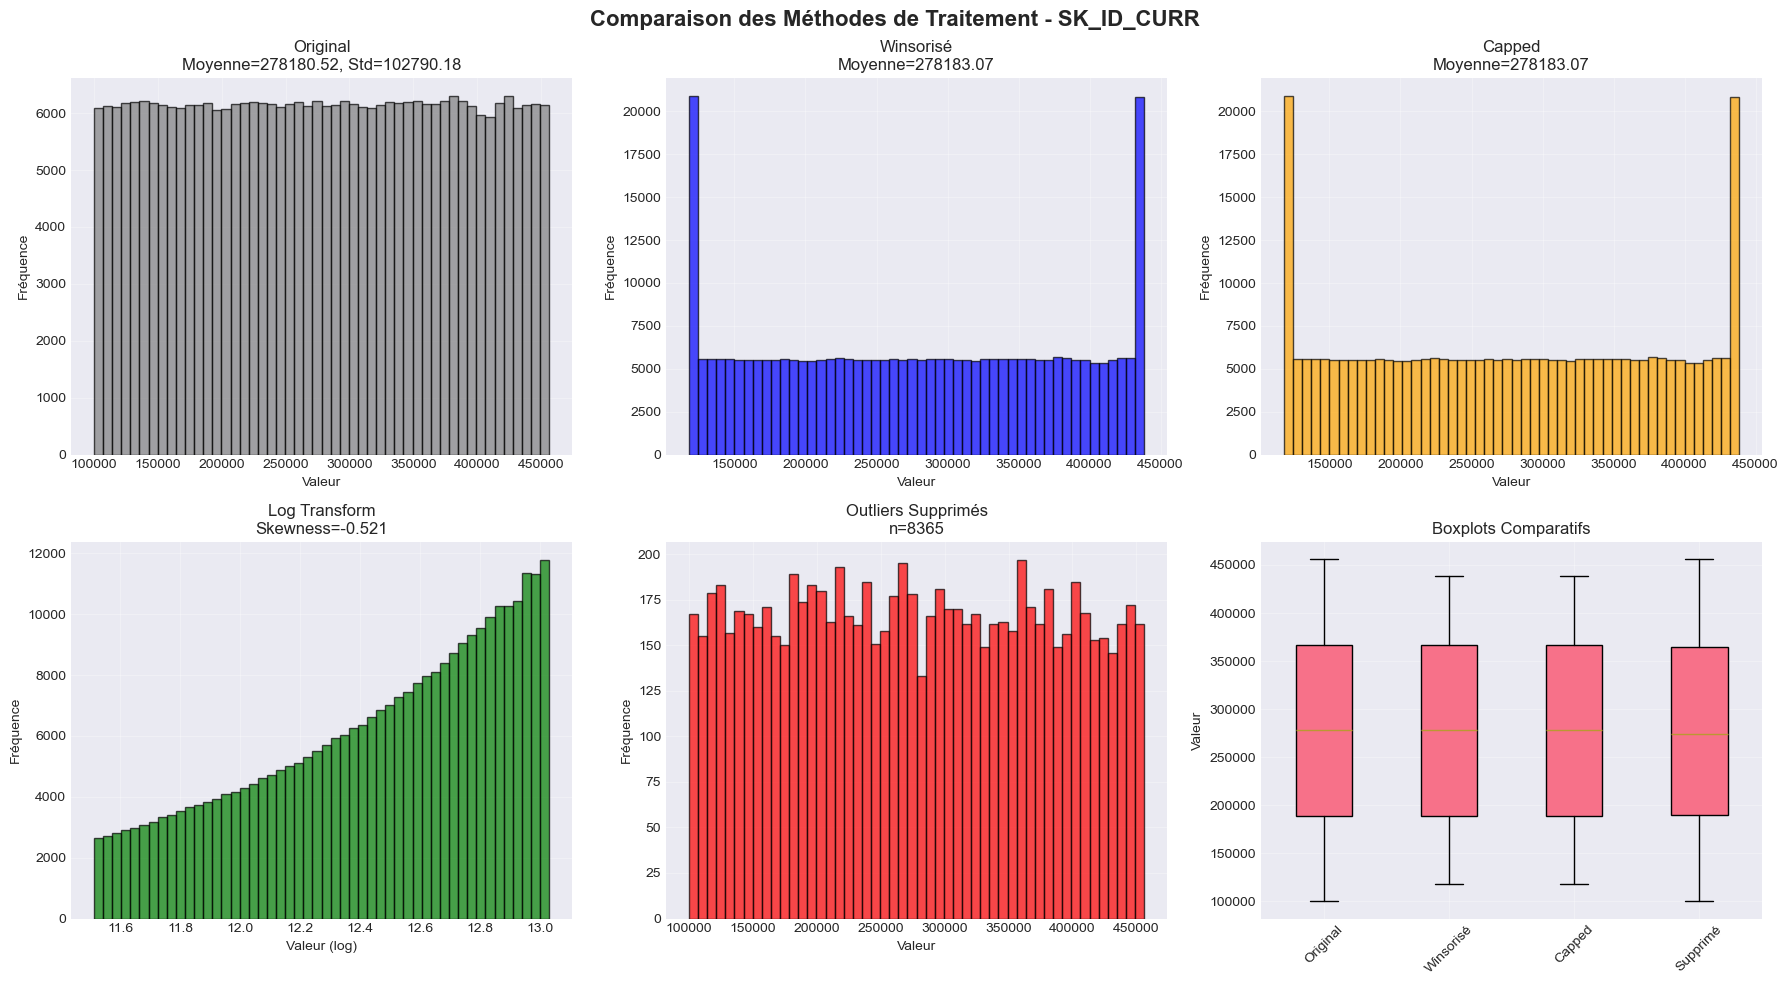

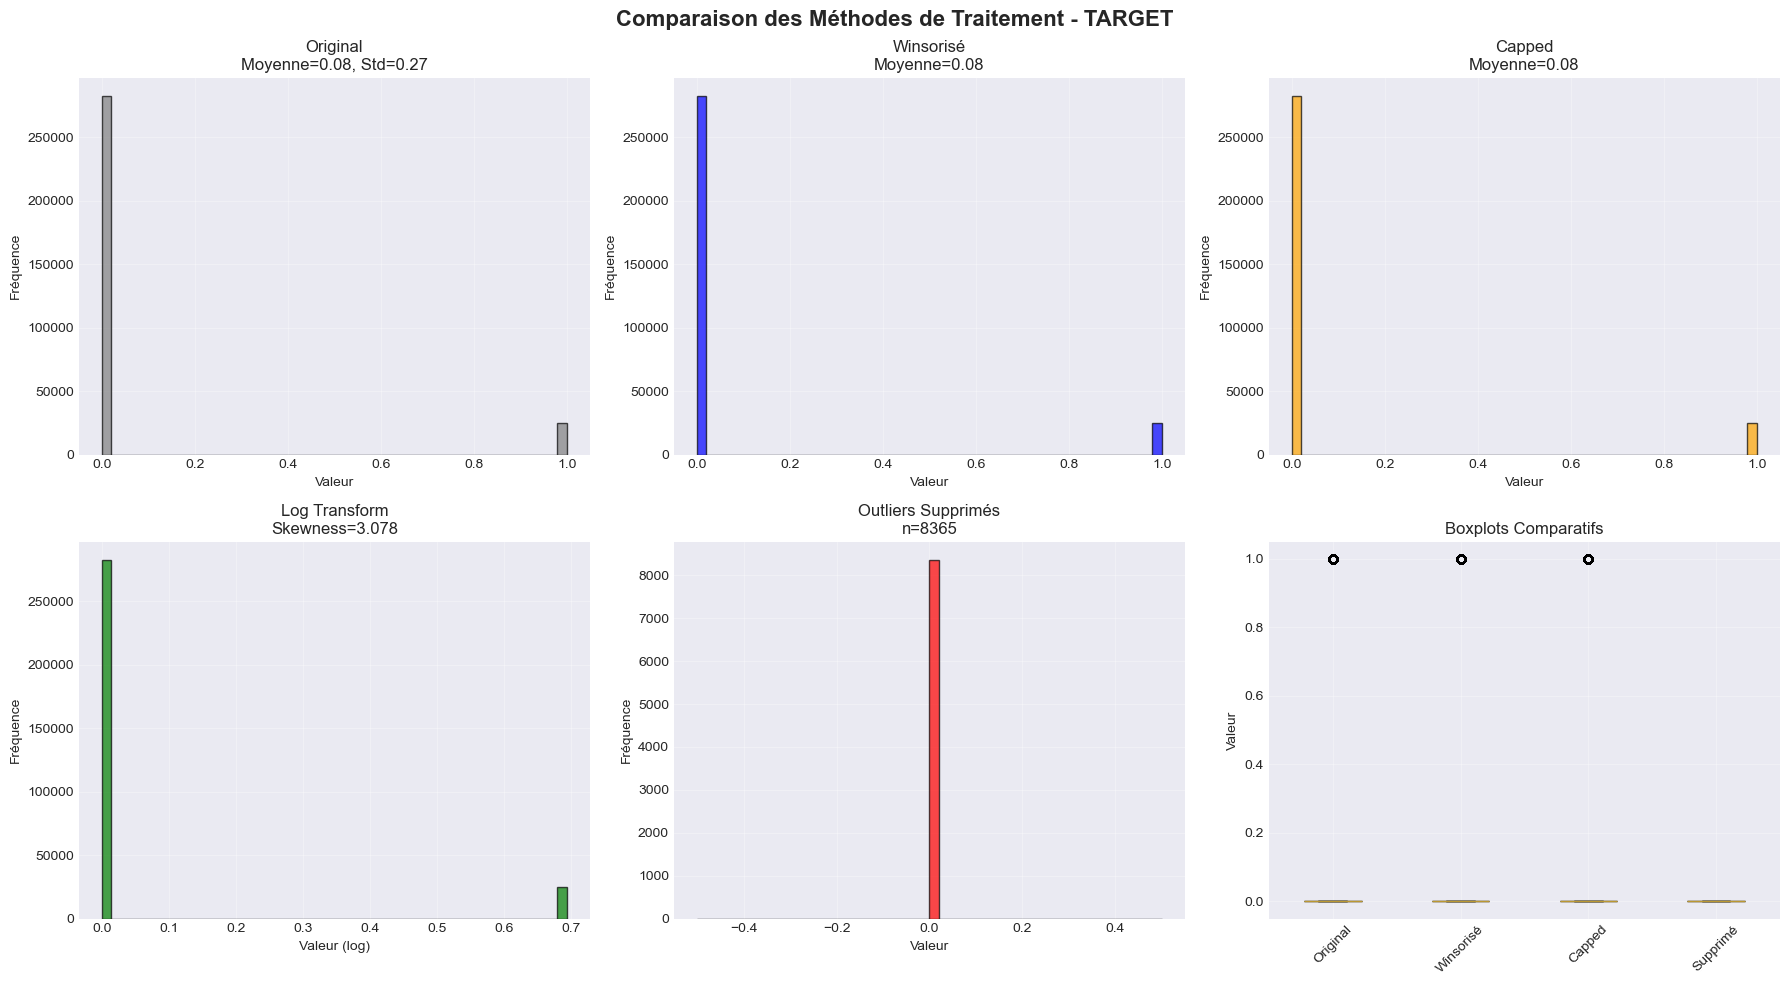

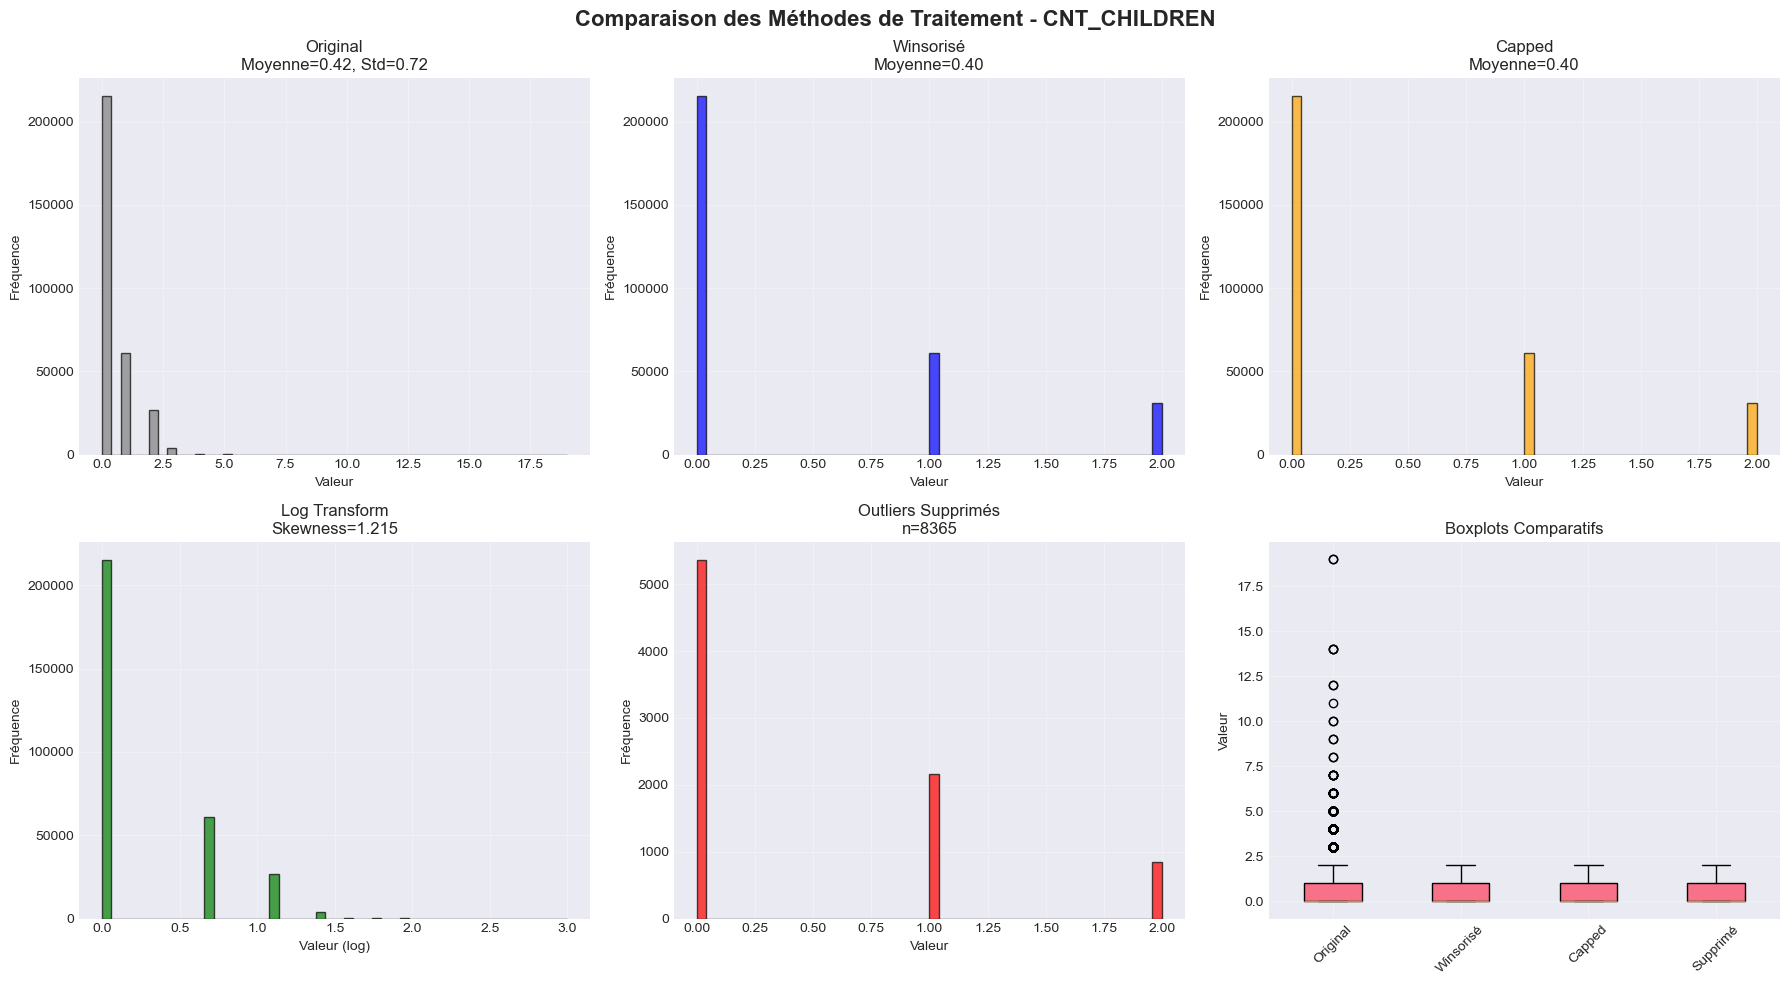

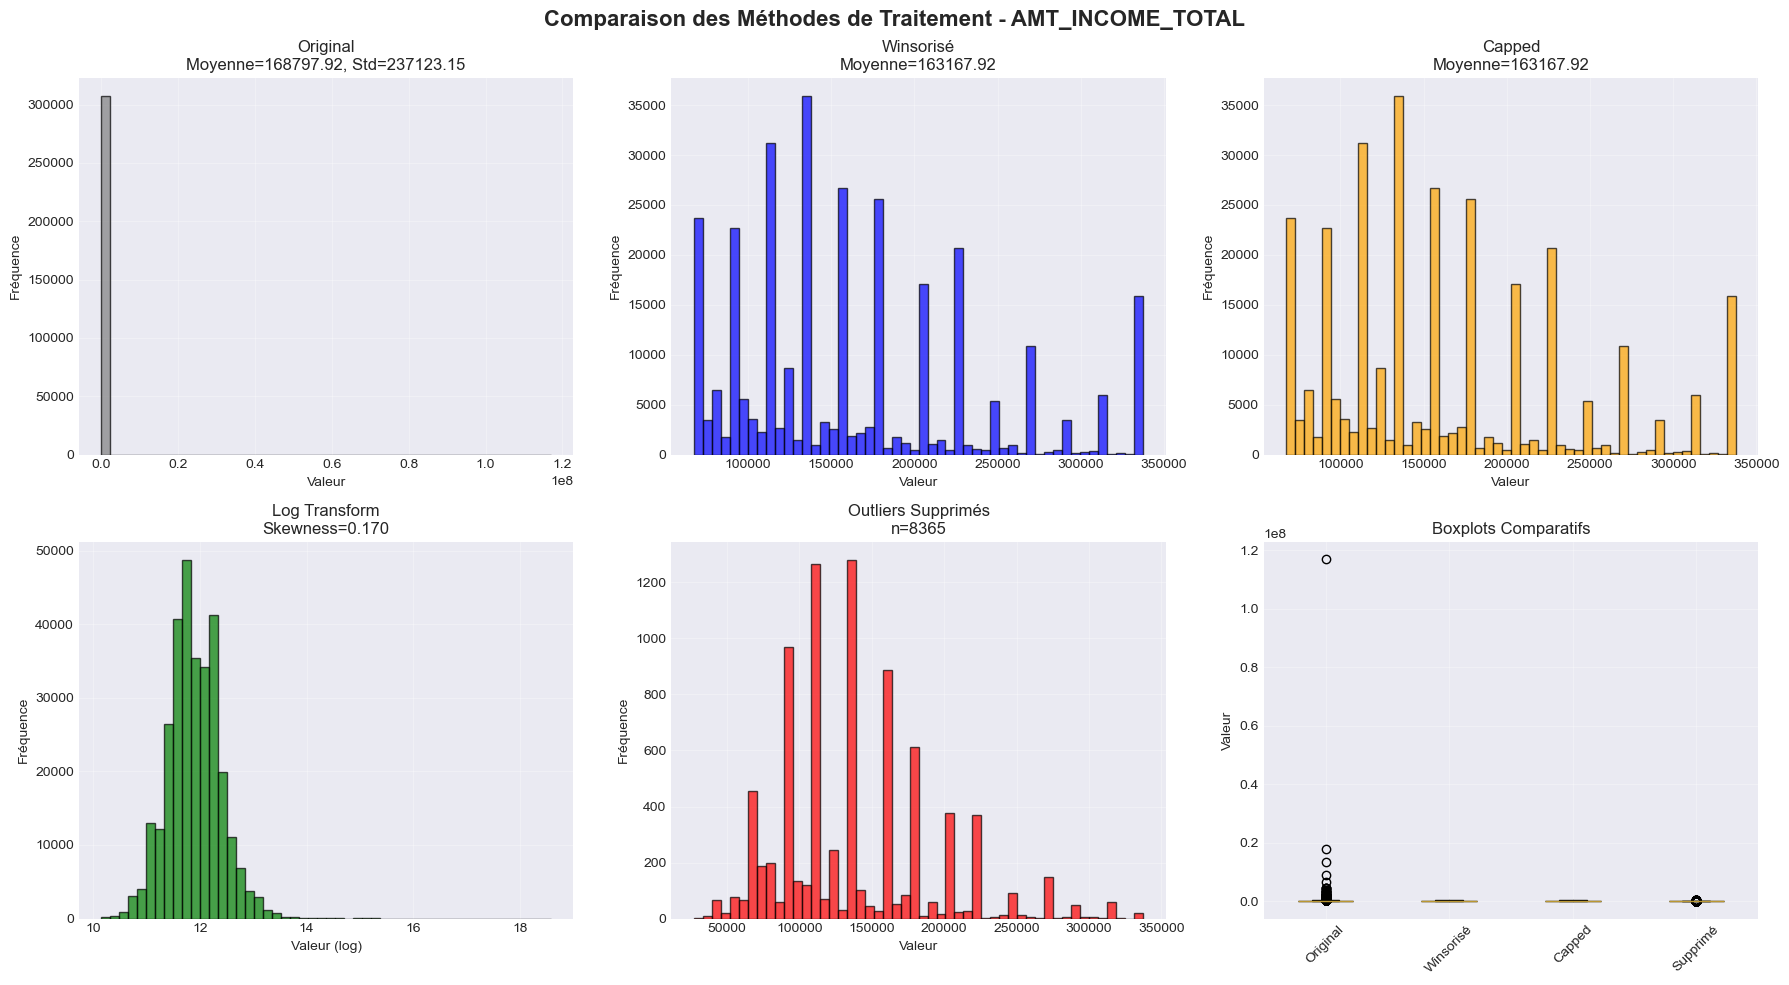

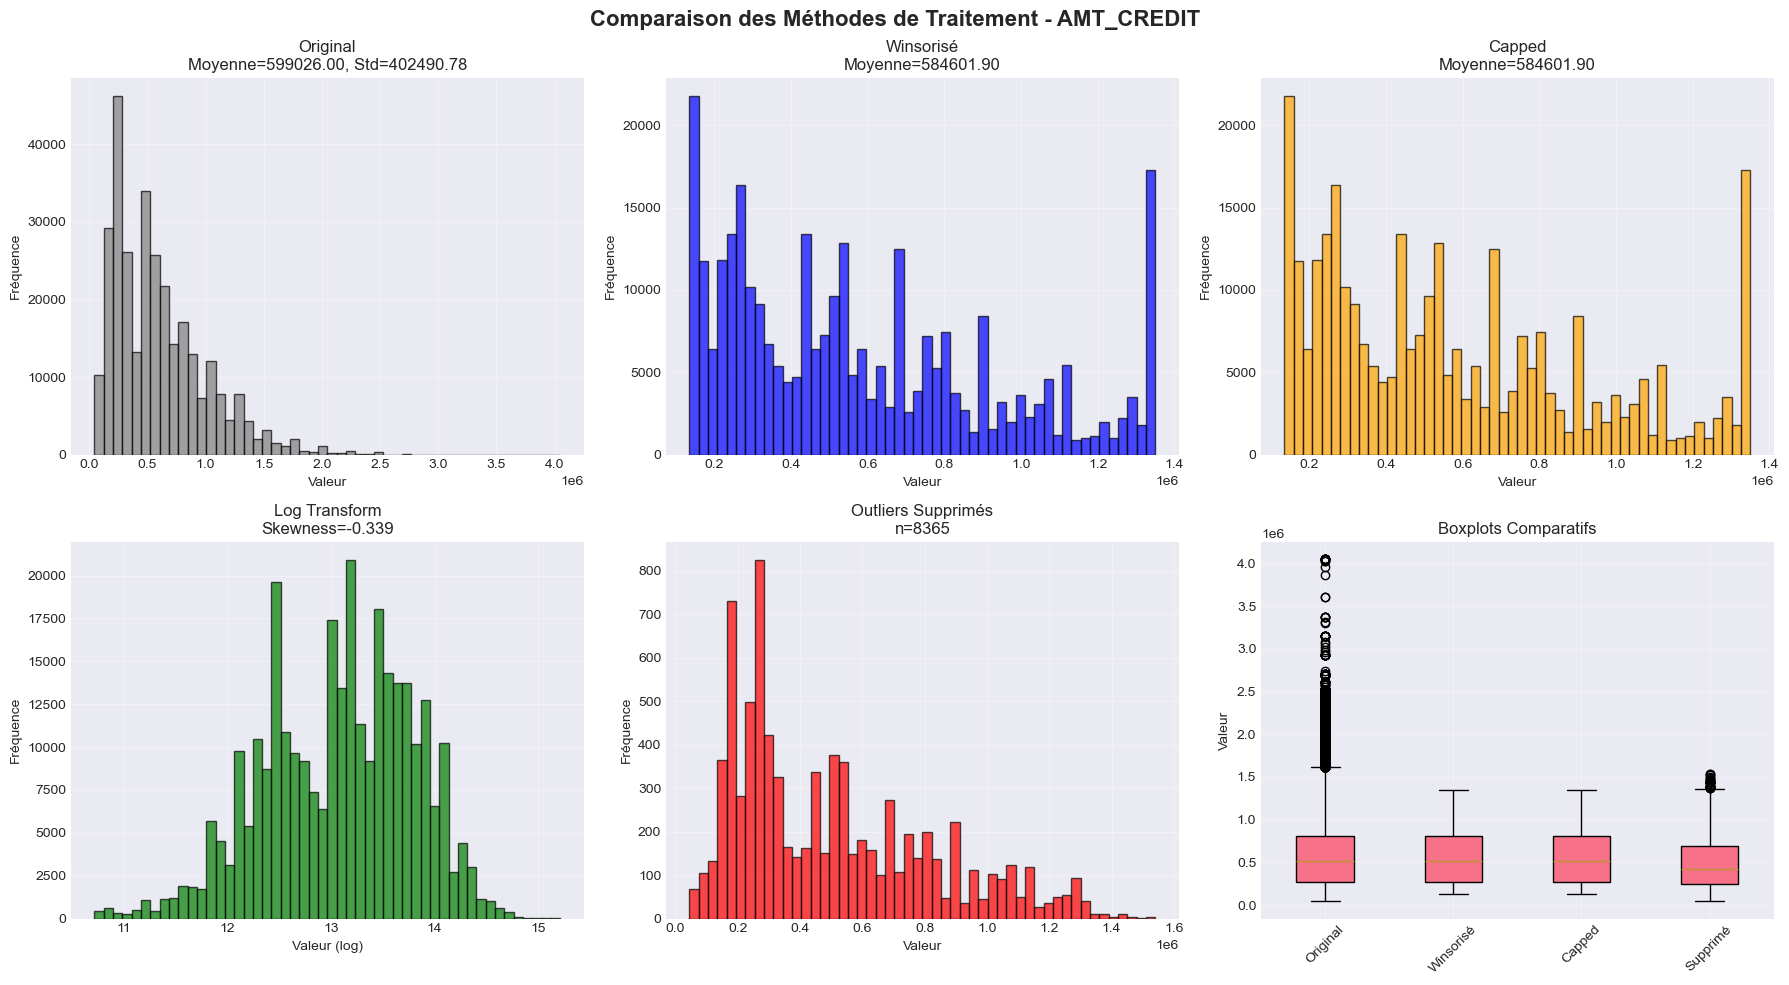

In [25]:


print("\n" + "=" * 80)
print("COMPARAISON GLOBALE DES MÉTHODES DE TRAITEMENT")
print("=" * 80)

# Créer un tableau comparatif
comparison_methods = []

for col in numeric_columns:
    original_stats = {
        'mean': df[col].mean(),
        'median': df[col].median(),
        'std': df[col].std(),
        'skew': df[col].skew(),
        'kurt': df[col].kurtosis()
    }
    
    # Statistiques après winsorisation
    if f'{col}_winsorized' in df_winsorized.columns:
        wins_stats = {
            'mean': df_winsorized[f'{col}_winsorized'].mean(),
            'std': df_winsorized[f'{col}_winsorized'].std(),
            'skew': df_winsorized[f'{col}_winsorized'].skew()
        }
    else:
        wins_stats = {'mean': np.nan, 'std': np.nan, 'skew': np.nan}
    
    # Statistiques après capping
    if f'{col}_capped' in df_capped.columns:
        cap_stats = {
            'mean': df_capped[f'{col}_capped'].mean(),
            'std': df_capped[f'{col}_capped'].std(),
            'skew': df_capped[f'{col}_capped'].skew()
        }
    else:
        cap_stats = {'mean': np.nan, 'std': np.nan, 'skew': np.nan}
    
    # Statistiques après transformation log
    if f'{col}_log' in df_log.columns:
        log_stats = {
            'mean': df_log[f'{col}_log'].mean(),
            'std': df_log[f'{col}_log'].std(),
            'skew': df_log[f'{col}_log'].skew()
        }
    else:
        log_stats = {'mean': np.nan, 'std': np.nan, 'skew': np.nan}
    
    # Statistiques après suppression
    clean_stats = {
        'mean': df_clean[col].mean(),
        'std': df_clean[col].std(),
        'skew': df_clean[col].skew()
    }
    
    comparison_methods.append({
        'Variable': col,
        'Métrique': 'Moyenne',
        'Original': f"{original_stats['mean']:.2f}",
        'Winsorisé': f"{wins_stats['mean']:.2f}",
        'Capped': f"{cap_stats['mean']:.2f}",
        'Log': f"{log_stats['mean']:.2f}",
        'Supprimé': f"{clean_stats['mean']:.2f}"
    })
    
    comparison_methods.append({
        'Variable': col,
        'Métrique': 'Écart-type',
        'Original': f"{original_stats['std']:.2f}",
        'Winsorisé': f"{wins_stats['std']:.2f}",
        'Capped': f"{cap_stats['std']:.2f}",
        'Log': f"{log_stats['std']:.2f}",
        'Supprimé': f"{clean_stats['std']:.2f}"
    })
    
    comparison_methods.append({
        'Variable': col,
        'Métrique': 'Skewness',
        'Original': f"{original_stats['skew']:.3f}",
        'Winsorisé': f"{wins_stats['skew']:.3f}",
        'Capped': f"{cap_stats['skew']:.3f}",
        'Log': f"{log_stats['skew']:.3f}",
        'Supprimé': f"{clean_stats['skew']:.3f}"
    })

comparison_methods_df = pd.DataFrame(comparison_methods)
print(f"\n{comparison_methods_df.to_string(index=False)}")

# Visualisation comparative pour chaque variable
for col in numeric_columns[:5]:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Comparaison des Méthodes de Traitement - {col}', fontsize=16, fontweight='bold')
    
    # Original
    axes[0, 0].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7, color='gray')
    axes[0, 0].set_title(f'Original\nMoyenne={df[col].mean():.2f}, Std={df[col].std():.2f}')
    axes[0, 0].set_xlabel('Valeur')
    axes[0, 0].set_ylabel('Fréquence')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Winsorisé
    if f'{col}_winsorized' in df_winsorized.columns:
        axes[0, 1].hist(df_winsorized[f'{col}_winsorized'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='blue')
        axes[0, 1].set_title(f'Winsorisé\nMoyenne={df_winsorized[f"{col}_winsorized"].mean():.2f}')
    axes[0, 1].set_xlabel('Valeur')
    axes[0, 1].set_ylabel('Fréquence')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Capped
    if f'{col}_capped' in df_capped.columns:
        axes[0, 2].hist(df_capped[f'{col}_capped'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='orange')
        axes[0, 2].set_title(f'Capped\nMoyenne={df_capped[f"{col}_capped"].mean():.2f}')
    axes[0, 2].set_xlabel('Valeur')
    axes[0, 2].set_ylabel('Fréquence')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Log
    if f'{col}_log' in df_log.columns:
        axes[1, 0].hist(df_log[f'{col}_log'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
        axes[1, 0].set_title(f'Log Transform\nSkewness={df_log[f"{col}_log"].skew():.3f}')
    axes[1, 0].set_xlabel('Valeur (log)')
    axes[1, 0].set_ylabel('Fréquence')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Supprimé
    axes[1, 1].hist(df_clean[col].dropna(), bins=50, edgecolor='black', alpha=0.7, color='red')
    axes[1, 1].set_title(f'Outliers Supprimés\nn={len(df_clean)}')
    axes[1, 1].set_xlabel('Valeur')
    axes[1, 1].set_ylabel('Fréquence')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Boxplots comparatifs
    data_boxplot = [df[col].dropna()]
    labels_boxplot = ['Original']
    
    if f'{col}_winsorized' in df_winsorized.columns:
        data_boxplot.append(df_winsorized[f'{col}_winsorized'].dropna())
        labels_boxplot.append('Winsorisé')
    
    if f'{col}_capped' in df_capped.columns:
        data_boxplot.append(df_capped[f'{col}_capped'].dropna())
        labels_boxplot.append('Capped')
    
    data_boxplot.append(df_clean[col].dropna())
    labels_boxplot.append('Supprimé')
    
    axes[1, 2].boxplot(data_boxplot, labels=labels_boxplot, patch_artist=True)
    axes[1, 2].set_title('Boxplots Comparatifs')
    axes[1, 2].set_ylabel('Valeur')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 12. RECOMMANDATIONS ET CHOIX DE LA MÉTHODE

In [ ]:

print("\n" + "=" * 80)
print("RECOMMANDATIONS POUR LE CHOIX DE LA MÉTHODE")
print("=" * 80)

for col in numeric_columns:
    print(f"\n{'─' * 80}")
    print(f"Variable: {col}")
    print(f"{'─' * 80}")
    
    outliers_pct = outliers_summary[col]['stats']['outliers_percentage']
    skewness = df[col].skew()
    has_negatives = (df[col] < 0).any()
    
    print(f"\nCaractéristiques:")
    print(f"  - Pourcentage d'outliers: {outliers_pct:.2f}%")
    print(f"  - Skewness: {skewness:.3f}")
    print(f"  - Contient des valeurs négatives: {'Oui' if has_negatives else 'Non'}")
    
    print(f"\nRecommandations:")
    
    # Critères de décision
    if outliers_pct < 1:
        print(f"  ✓ Très peu d'outliers (<1%) → SUPPRESSION recommandée")
        print(f"    Impact minimal sur la taille du dataset")
    elif outliers_pct < 5:
        print(f"  ✓ Peu d'outliers (<5%) → SUPPRESSION ou WINSORISATION")
        print(f"    Choix selon l'importance de préserver toutes les observations")
    else:
        print(f"  ✓ Beaucoup d'outliers (≥5%) → WINSORISATION ou CAPPING")
        print(f"    Suppression déconseillée (perte de données importante)")
    
    if abs(skewness) > 1:
        if not has_negatives:
            print(f"  ✓ Distribution très asymétrique → TRANSFORMATION LOG recommandée")
            print(f"    Pour normaliser la distribution avant modélisation")
        else:
            print(f"  ⚠ Distribution asymétrique mais valeurs négatives présentes")
            print(f"    → Transformation log impossible, privilégier WINSORISATION")
    
    if has_negatives:
        print(f"  ⚠ Présence de valeurs négatives → Transformation log non applicable")


# ============================================================================
# 13. EXPORT DES DONNÉES TRAITÉES
# ============================================================================

In [ ]:

print("\n" + "=" * 80)
print("EXPORT DES DONNÉES TRAITÉES")
print("=" * 80)

# Sauvegarder chaque version traitée
df_winsorized.to_csv('data_winsorized.csv', index=False)
print("\n✓ Données winsorisées exportées: data_winsorized.csv")

df_capped.to_csv('data_capped.csv', index=False)
print("✓ Données avec capping exportées: data_capped.csv")

df_log.to_csv('data_log_transformed.csv', index=False)
print("✓ Données avec transformation log exportées: data_log_transformed.csv")

df_clean.to_csv('data_outliers_removed.csv', index=False)
print("✓ Données sans outliers exportées: data_outliers_removed.csv")

# ============================================================================
# 14. RÉSUMÉ FINAL ET SYNTHÈSE
# ============================================================================

In [ ]:

print("\n" + "=" * 80)
print("SYNTHÈSE FINALE - TRAITEMENT DES OUTLIERS")
print("=" * 80)

print(f"\n📊 Dataset original:")
print(f"  - Nombre d'observations: {len(df)}")
print(f"  - Nombre de variables numériques: {len(numeric_columns)}")

print(f"\n🔍 Outliers détectés (méthode IQR):")
total_outliers = sum([outliers_summary[col]['stats']['outliers_count'] for col in numeric_columns])
print(f"  - Total d'outliers: {total_outliers}")
for col in numeric_columns:
    count = outliers_summary[col]['stats']['outliers_count']
    pct = outliers_summary[col]['stats']['outliers_percentage']
    print(f"    • {col}: {count} outliers ({pct:.2f}%)")

print(f"\n🔧 Méthodes de traitement appliquées:")
print(f"  1. Winsorisation (5%-95%)")
print(f"  2. Capping (5%-95%)")
print(f"  3. Transformation logarithmique")
print(f"  4. Suppression des outliers")

print(f"\n💾 Fichiers générés:")
print(f"  - data_winsorized.csv")
print(f"  - data_capped.csv")
print(f"  - data_log_transformed.csv")
print(f"  - data_outliers_removed.csv")

print(f"\n📈 Impact sur la taille du dataset:")
print(f"  - Original: {len(df)} observations")
print(f"  - Après suppression: {len(df_clean)} observations ({len(df_clean)/len(df)*100:.1f}%)")
print(f"  - Observations supprimées: {len(df) - len(df_clean)} ({(len(df)-len(df_clean))/len(df)*100:.1f}%)")

print(f"\n✅ Analyse des outliers terminée avec succès!")
print("=" * 80)